In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
import seaborn as sns
import warnings
from scipy.stats import entropy
from sklearn.cluster import DBSCAN

warnings.filterwarnings("ignore")
import os
import glob

matplotlib.rcParams['figure.dpi'] = 300

def getDF(df_raw, featurename):
    #columnname = [featurename]
    #df_extract = df_raw.loc[:, columnname].copy()
    df_extract = df_raw.copy()

    #if 'Time' in df_raw.columns:
    #    df_extract.index = pd.to_datetime(df_raw["Time"],
    #                                      format='%Y-%m-%d %H:%M:%S')
    if 'date' in df_raw.columns:
        df_extract.index = pd.to_datetime(df_raw["date"], format='%Y-%m-%d')


    # Transfer datetime
    #     from datetime import datetime

    df_extract['DoW'] = [''] * len(df_extract)
    df_extract['Month'] = [''] * len(df_extract)
    df_extract['Date'] = [''] * len(df_extract)
    df_extract['Hour'] = [''] * len(df_extract)
    df_extract['Week'] = [''] * len(df_extract)
    df_extract['Minute'] = [''] * len(df_extract)

    for i,(indx, eachrow) in enumerate(df_extract.iterrows()):
        if i%50 == 0:
            print(i)
        df_extract['DoW'].loc[indx] = (indx.strftime('%A'))
        df_extract['Month'].loc[indx] = int(indx.month)
        df_extract['Date'].loc[indx] = (indx.strftime("%Y/%m/%d"))
        df_extract['Hour'].loc[indx] = int(indx.strftime("%H"))
        df_extract['Minute'].loc[indx] = int(indx.strftime("%M"))
        df_extract['Week'].loc[indx] = int(indx.strftime('%W'))
    return df_extract


def getDF_bymonth(df_raw, featurename, month):
    columnname = [featurename]
    df_extract = df_raw.loc[:, columnname].copy()
    if 'Time' in df_raw.columns:
        df_extract.index = pd.to_datetime(df_raw["Time"],
                                          format='%Y-%m-%d %H:%M:%S')

    # Transfer datetime
    #     from datetime import datetime

    df_extract['DoW'] = [''] * len(df_extract)
    df_extract['Month'] = [''] * len(df_extract)
    df_extract['Date'] = [''] * len(df_extract)
    df_extract['Hour'] = [''] * len(df_extract)
    df_extract['Week'] = [''] * len(df_extract)
    df_extract['Minute'] = [''] * len(df_extract)
    for indx, eachrow in df_extract.iterrows():
        df_extract['DoW'].loc[indx] = (indx.strftime('%A'))
        df_extract['Month'].loc[indx] = int(indx.month)
        df_extract['Date'].loc[indx] = (indx.strftime("%Y/%m/%d"))
        df_extract['Hour'].loc[indx] = int(indx.strftime("%H"))
        df_extract['Minute'].loc[indx] = int(indx.strftime("%M"))
        df_extract['Week'].loc[indx] = int(indx.strftime('%U'))
    df_monthsplit_extract = df_extract.loc[df_extract['Month'] == month]
    return df_monthsplit_extract

# Compute timeseries statistics and plot for individual patients

In [2]:
dir_ = "/home/reinhold/Daten/Paper_Datasets_Nov2022"
filenames = [r'OpenAPS complete_patient_statistics.xlsx',
    r'OPENonOH complete_patient_statistics.xlsx'] # Specify the file path

df_all_stat = {}
df_all_stat["OpenAPS"] = pd.read_excel(os.path.join(dir_, filenames[0]))  # all columns
df_all_stat["OPENonOH"] = pd.read_excel(os.path.join(dir_, filenames[1]))
print(len(df_all_stat["OPENonOH"].loc[df_all_stat["OPENonOH"]["id"].isna()]), df_all_stat["OPENonOH"].loc[df_all_stat["OPENonOH"]["id"].isna()])
df_all_stat["OpenAPS"]["id"] = df_all_stat["OpenAPS"]["id"].astype(int)
df_all_stat["OPENonOH"]["id"] = df_all_stat["OPENonOH"]["id"].astype(int)
print(len(df_all_stat["OPENonOH"].columns), df_all_stat["OPENonOH"].columns)


0 Empty DataFrame
Columns: [id, age, gender, height, weight, country, year, month, gender_int, is_child, interdaysd, interdaycv, bg_roc_stds, TOR<70, TIR, TOR>180, POR, J_index, LGBI, HBGI, GMI, count, mean, std, min, 0.25, 0.5, 0.75, max]
Index: []

[0 rows x 29 columns]
29 Index([         'id',         'age',      'gender',      'height',
            'weight',     'country',        'year',       'month',
        'gender_int',    'is_child',  'interdaysd',  'interdaycv',
       'bg_roc_stds',      'TOR<70',         'TIR',     'TOR>180',
               'POR',     'J_index',        'LGBI',        'HBGI',
               'GMI',       'count',        'mean',         'std',
               'min',          0.25,           0.5,          0.75,
               'max'],
      dtype='object')


In [3]:
root_dir = "/home/reinhold/Daten/dana_processing/"
sub_dir =['OpenAPS_NS_Data', 'OpenAPS_AAPS_Uploader_Data', 'OPENonOH_NS_Data', 'OPENonOH_AAPS_Uploader_Data']
filenames_per_day = ['OpenAPS_NS_per_day.csv', 'OpenAPS_AAPS_Uploader_per_day.csv', 'OPENonOH_NS_per_day.csv', 'OPENonOH_AAPS_Uploader_per_day.csv']

df_per_day = {}
df1 = []
for i in range(len(sub_dir)):
    df1.append(pd.read_csv(os.path.join(root_dir, sub_dir[i], filenames_per_day[i])))
df_per_day["OpenAPS"] = pd.concat([df1[0], df1[1]], axis=0)
df_per_day["OPENonOH"] = pd.concat([df1[2], df1[3]], axis=0)
df_per_day["OpenAPS"]["pm_id"] = df_per_day["OpenAPS"]["pm_id"].astype(int)
df_per_day["OPENonOH"]["pm_id"] = df_per_day["OPENonOH"]["pm_id"].astype(int)
print(len(df_per_day["OPENonOH"].columns), df_per_day["OPENonOH"].columns)

9 Index(['Unnamed: 0', 'date', 'sgv_mean', 'sgv_std', 'sgv_min', 'sgv_max',
       'sgv_count', 'filename', 'pm_id'],
      dtype='object')


# join the statistics and the per day data

In [4]:
df = {}
df["OpenAPS"] = pd.merge(df_all_stat["OpenAPS"], df_per_day["OpenAPS"], left_on='id', right_on='pm_id', how='inner')
df["OPENonOH"] = pd.merge(df_all_stat["OPENonOH"], df_per_day["OPENonOH"], left_on='id', right_on='pm_id', how='inner')

print(df_per_day["OpenAPS"]["pm_id"].unique().shape, df_per_day["OPENonOH"]["pm_id"].unique().shape)
print(df_all_stat["OpenAPS"]["id"].unique().shape, df_all_stat["OPENonOH"]["id"].unique().shape)
print(df["OpenAPS"]["id"].unique().shape, df["OPENonOH"]["id"].unique().shape)
print(df["OpenAPS"]["id"].shape, df["OPENonOH"]["id"].shape)

print(set(df_all_stat["OPENonOH"]["id"].tolist()) - set(df["OPENonOH"]["id"].tolist()))
#print(df_all_stat["OPENonOH"].loc[ not in df["OPENonOH"]["id"].tolist(),"id"])
#print(df["OpenAPS"].loc[df["OpenAPS"]["id"] not in df_all_stat["OpenAPS"]["id"].values, "id"].unique(), df_all_stat["OpenAPS"]["id"])


(130,) (95,)
(122,) (75,)
(83,) (74,)
(25312,) (37650,)
{46968717}


In [5]:
print(df["OPENonOH"].columns)
df2 = df["OPENonOH"][["id", "gender", "sgv_mean", "sgv_std", "filename", "date"]]
df2["DoW"] = df2["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").weekday())
df2["DoW_str"] = df2["DoW"].apply(lambda x: "Monday" if x == 0 else "Tuesday" if x == 1 else "Wednesday" if x == 2 else "Thursday" if x == 3 else "Friday" if x == 4 else "Saturday" if x == 5 else "Sunday")
df2["year"] = df2["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").year)
df2["month"] = df2["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").month)
df2["day"] = df2["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").day)
#from pandasgui import show
#show(df2)


Index([         'id',         'age',      'gender',      'height',
            'weight',     'country',        'year',       'month',
        'gender_int',    'is_child',  'interdaysd',  'interdaycv',
       'bg_roc_stds',      'TOR<70',         'TIR',     'TOR>180',
               'POR',     'J_index',        'LGBI',        'HBGI',
               'GMI',       'count',        'mean',         'std',
               'min',          0.25,           0.5,          0.75,
               'max',  'Unnamed: 0',        'date',    'sgv_mean',
           'sgv_std',     'sgv_min',     'sgv_max',   'sgv_count',
          'filename',       'pm_id'],
      dtype='object')


In [6]:
df_yearly = []
year_offset = 2014
dir_ = "/home/reinhold/Daten/Paper_Datasets_Nov2022/results/yearly"
year_count_pm_ids, year_count_measurements = {}, {}
for i in range(1, 8):
    df_yearly.append(pd.read_csv(os.path.join(dir_, f"y{i}_stats.csv")))
    year_count_pm_ids[year_offset + i] = df_yearly[len(df_yearly)-1].loc[df_yearly[len(df_yearly)-1]["count"] > 0, "count"].count()
    
    year_count_measurements[year_offset + i] = df_yearly[len(df_yearly)-1].loc[df_yearly[len(df_yearly)-1]["count"] > 0, "count"].sum()

#print(year_count_pm_ids)
#print(year_count_measurements)

#df11 = pd.concat(df_yearly, axis=0)


In [7]:


#df10 = df_per_day["OpenAPS"]
#df10["year"] = df10["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").year)
df11 = df2[["year", "id"]].drop_duplicates()
#print(df11)


In [8]:
year_pm_ids = []
for i in year_count_pm_ids.keys():
    # year_count_pm_ids[i] is the count of pm_ids for year i
    for j in range(year_count_pm_ids[i]):
        year_pm_ids.append([i, j])

#print(year_pm_ids)


2015 2022
[240] [2014.5 2022.5]
[194] [2014.5 2022.5]


Text(0.5, 1.0, 'PwD active in a given year')

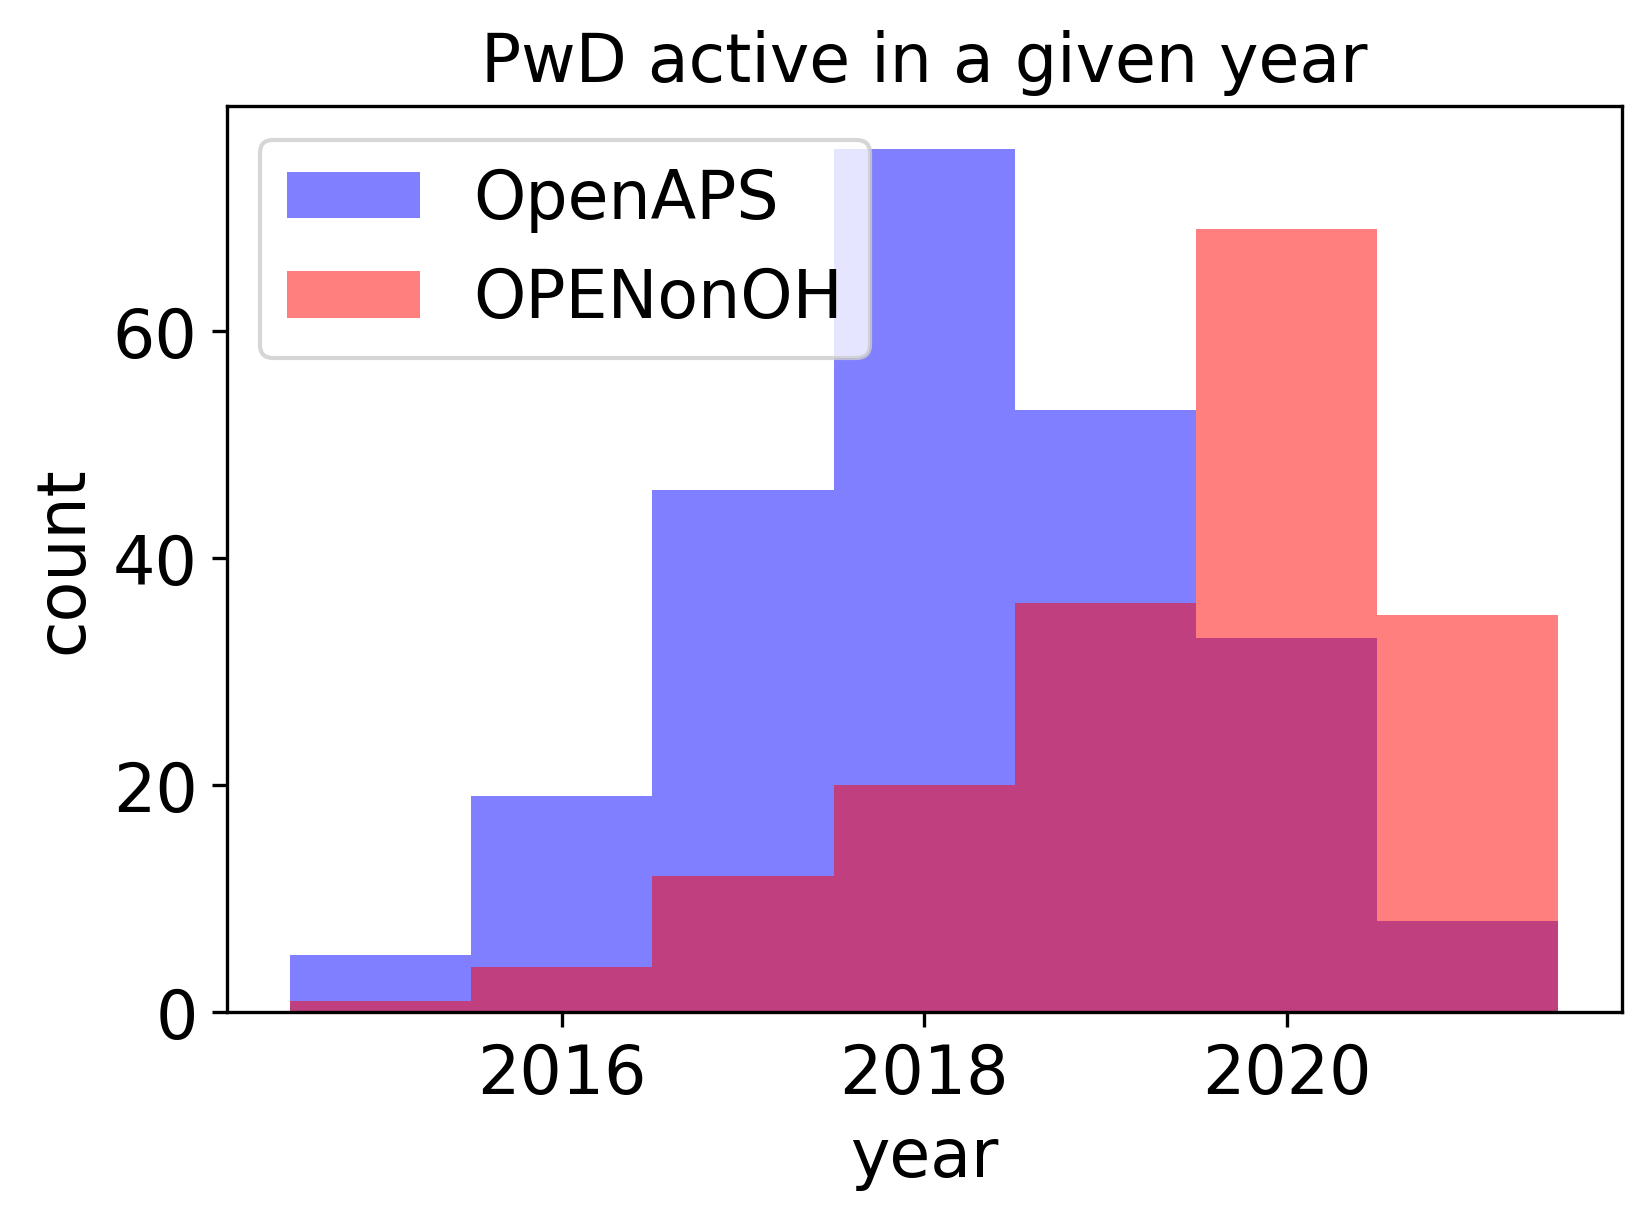

In [9]:
plt.rcParams.update({'font.size': 30, 'legend.fontsize': 16, 'legend.title_fontsize': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16})
df10 = pd.DataFrame(data=year_pm_ids, columns=["year", "count"])
min_, max_ = min(df11["year"].min(),df10["year"].min()), max(df11["year"].max(),df10["year"].max())
print(min_, max_)
counts_OpenAPS, bins_OpenAPS = np.histogram(df10["year"], bins=[min_ - 0.5, max_ + 0.5])
counts_OPENonOH, bins_OPENonOH = np.histogram(df11["year"], bins=[min_ - 0.5, max_ + 0.5])
#print(counts_OpenAPS, bins_OpenAPS)
#print(counts_OPENonOH, bins_OPENonOH)
#min_, max_ = df10["year"].min(), df10["year"].max()
plt.hist(df10["year"], bins=np.arange(min_ -0.5, max_ + 0.5), color="blue", label="OpenAPS", alpha=0.5)
#min_, max_ = df2["year"].min(), df2["year"].max()
plt.hist(df11["year"], bins=np.arange(min_ -0.5, max_ + 0.5), color="red", label="OPENonOH", alpha=0.5)
plt.legend()
plt.xlabel("year")
plt.ylabel("count")
plt.title("PwD active in a given year")
#plt.stairs(counts_OPENonOH, bins=bins_OPENonOH, color="red", label="OPENonOH")

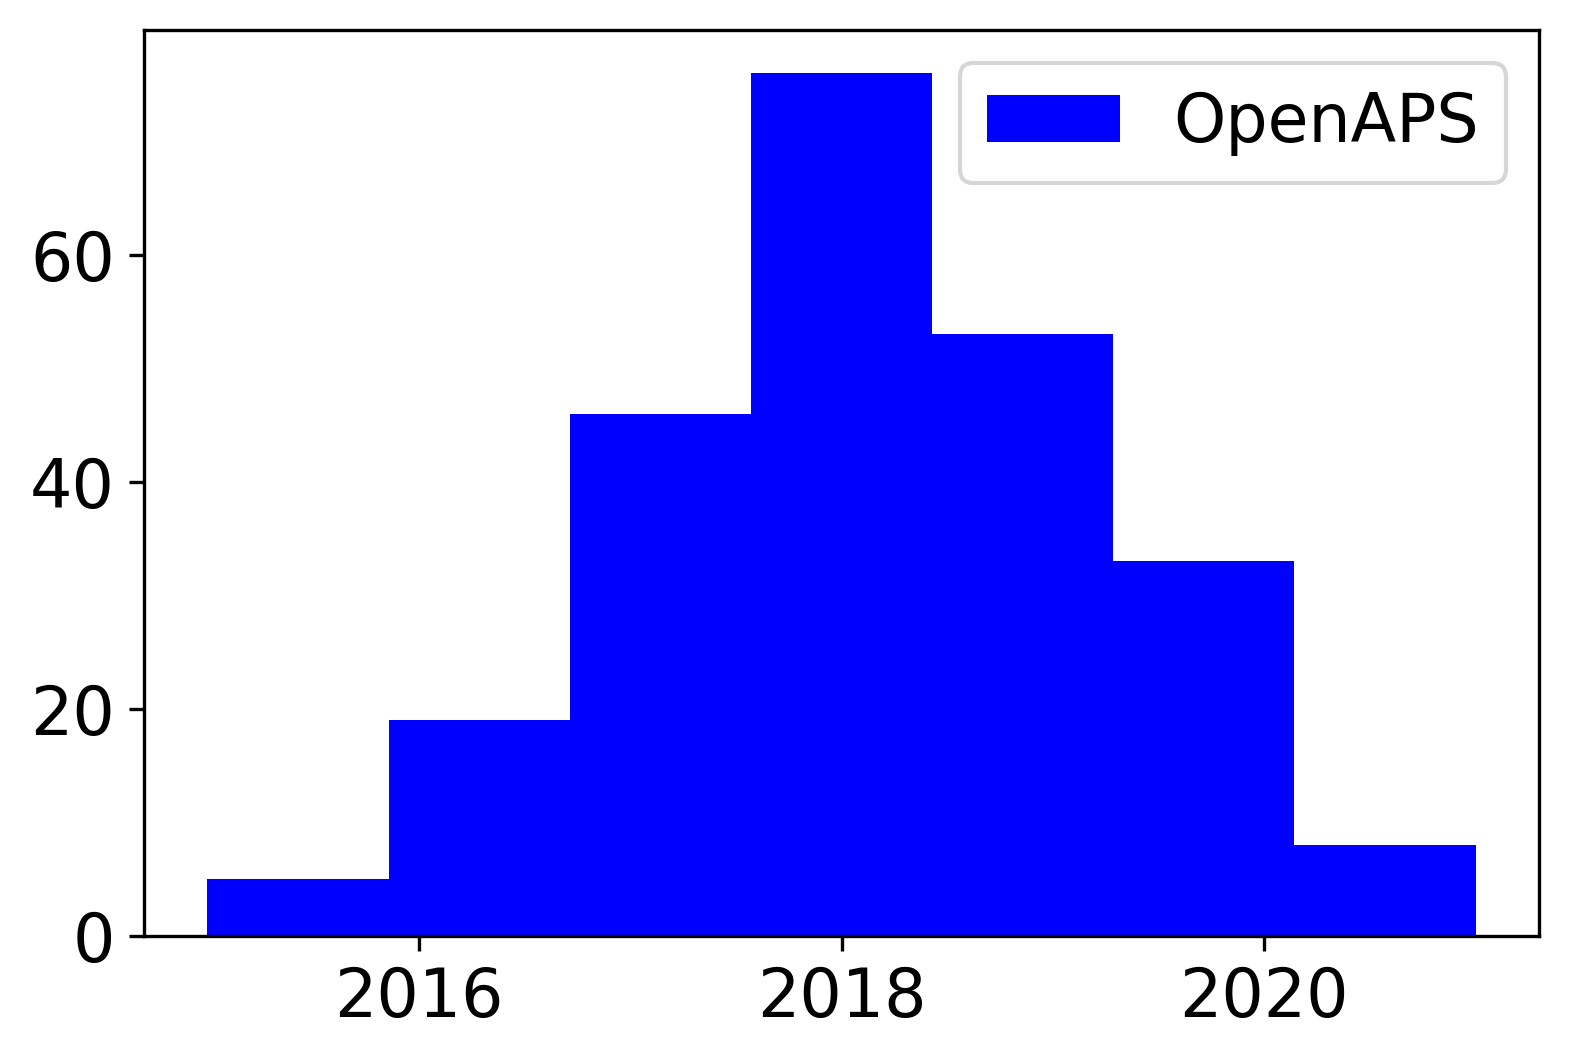

In [10]:
min_, max_ = df10["year"].min(), df10["year"].max()
plt.hist(df10["year"], bins=max_ - min_ + 1, color="blue", label="OpenAPS")
plt.legend()


In [17]:
def df_groupedby(df, gender = "Male", var = "DoW"):
    df_grby = df.loc[df["gender"] == gender, :].groupby(by=var).mean()
    df_grby[var] = df_grby.index
    if var == "DoW": 
        df_grby["DoW_str"] = df_grby["DoW"].apply(lambda x: "Monday" if x == 0 else "Tuesday" if x == 1 else "Wednesday" if x == 2 else "Thursday" if x == 3 else "Friday" if x == 4 else "Saturday" if x == 5 else "Sunday")
    return df_grby


In [18]:

df3 = {}
for var in ["DoW", "day", "month"]:
    df3[var] = {}
    for gender in ["Female", "Male"]:
        df3[var][gender] = df_groupedby(df2, gender, var)
#print(df3)

# Average statistics using timeseries breakdown on daily basis and classification based on gender

# Plot daily average statistics

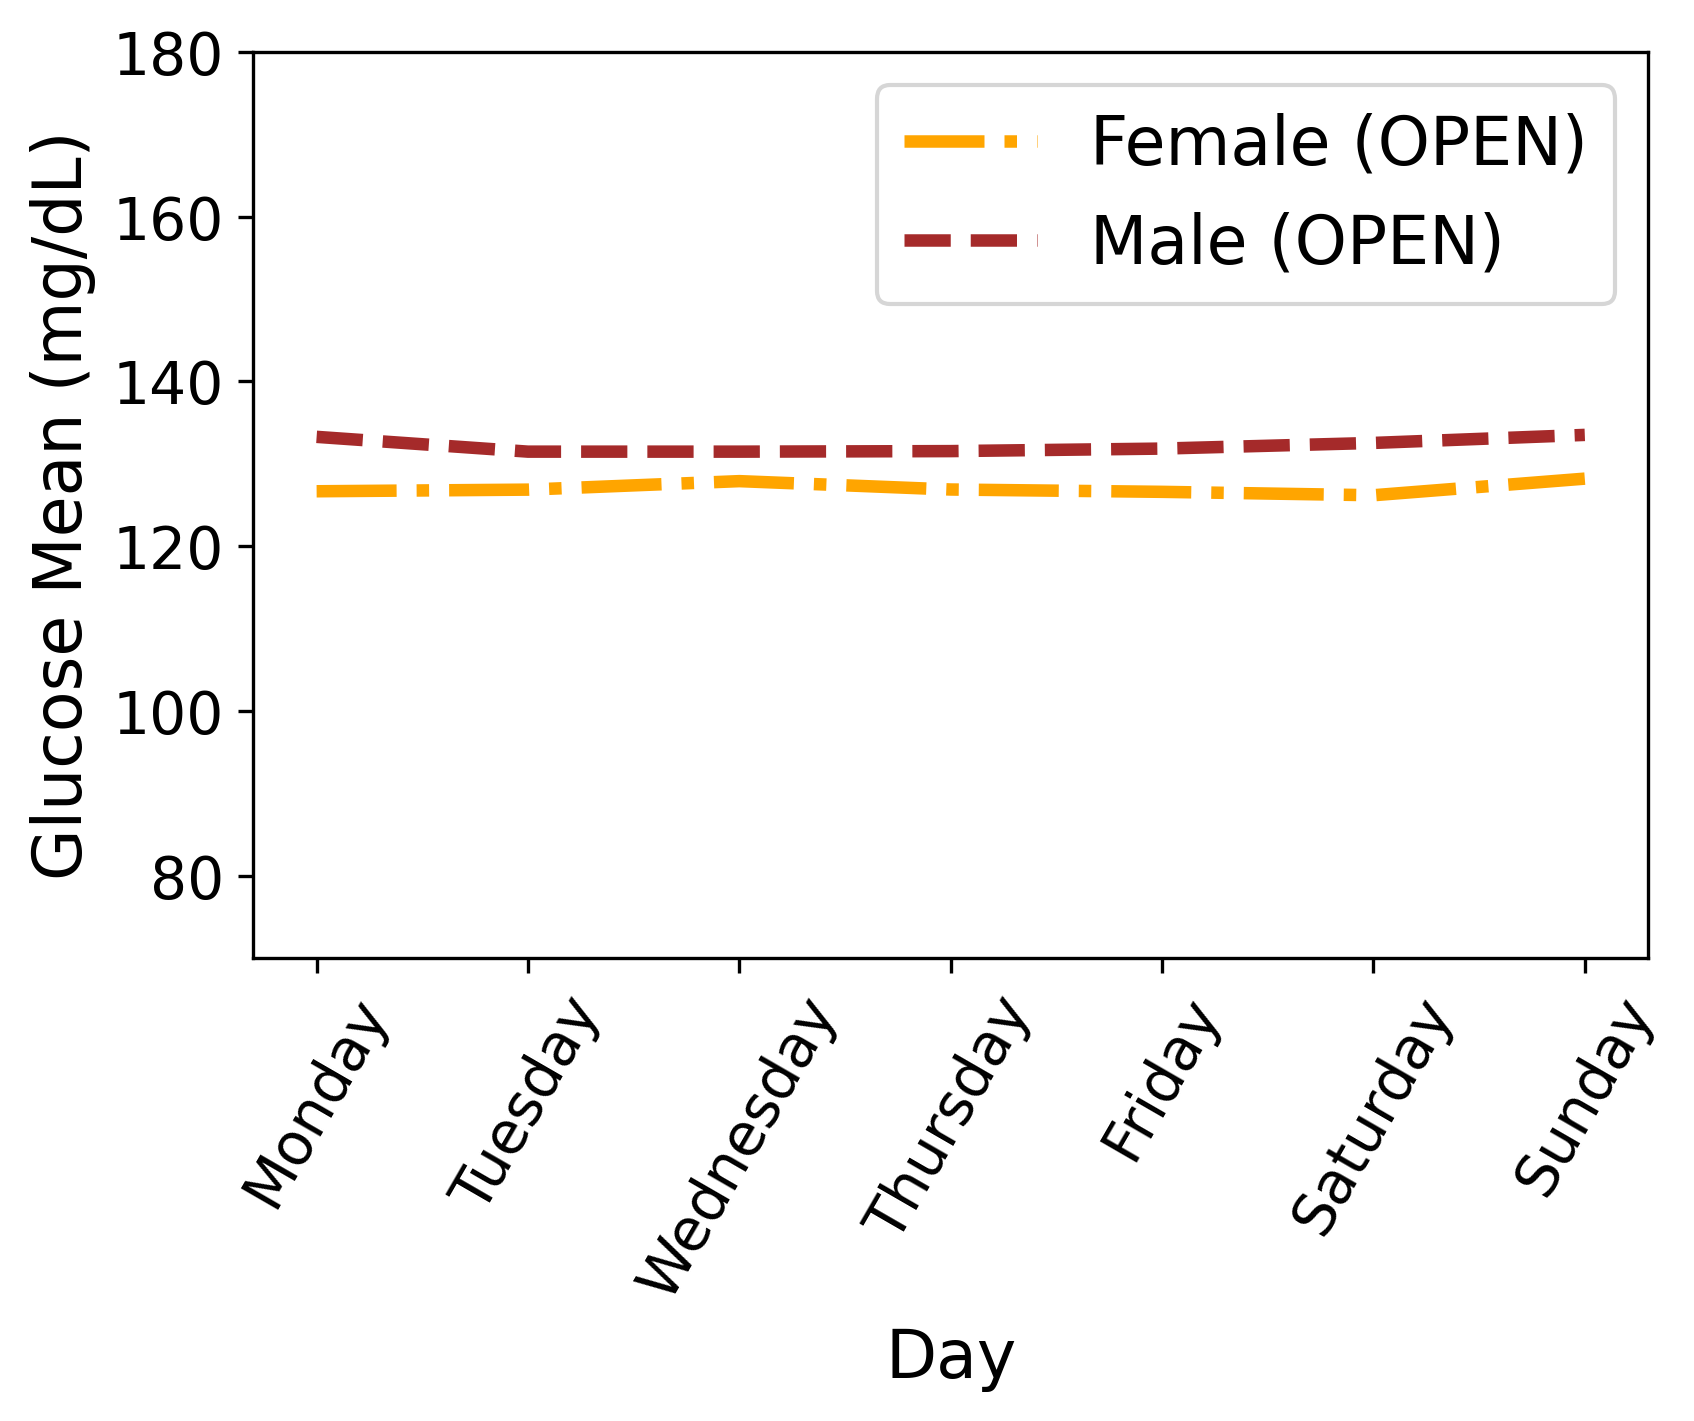

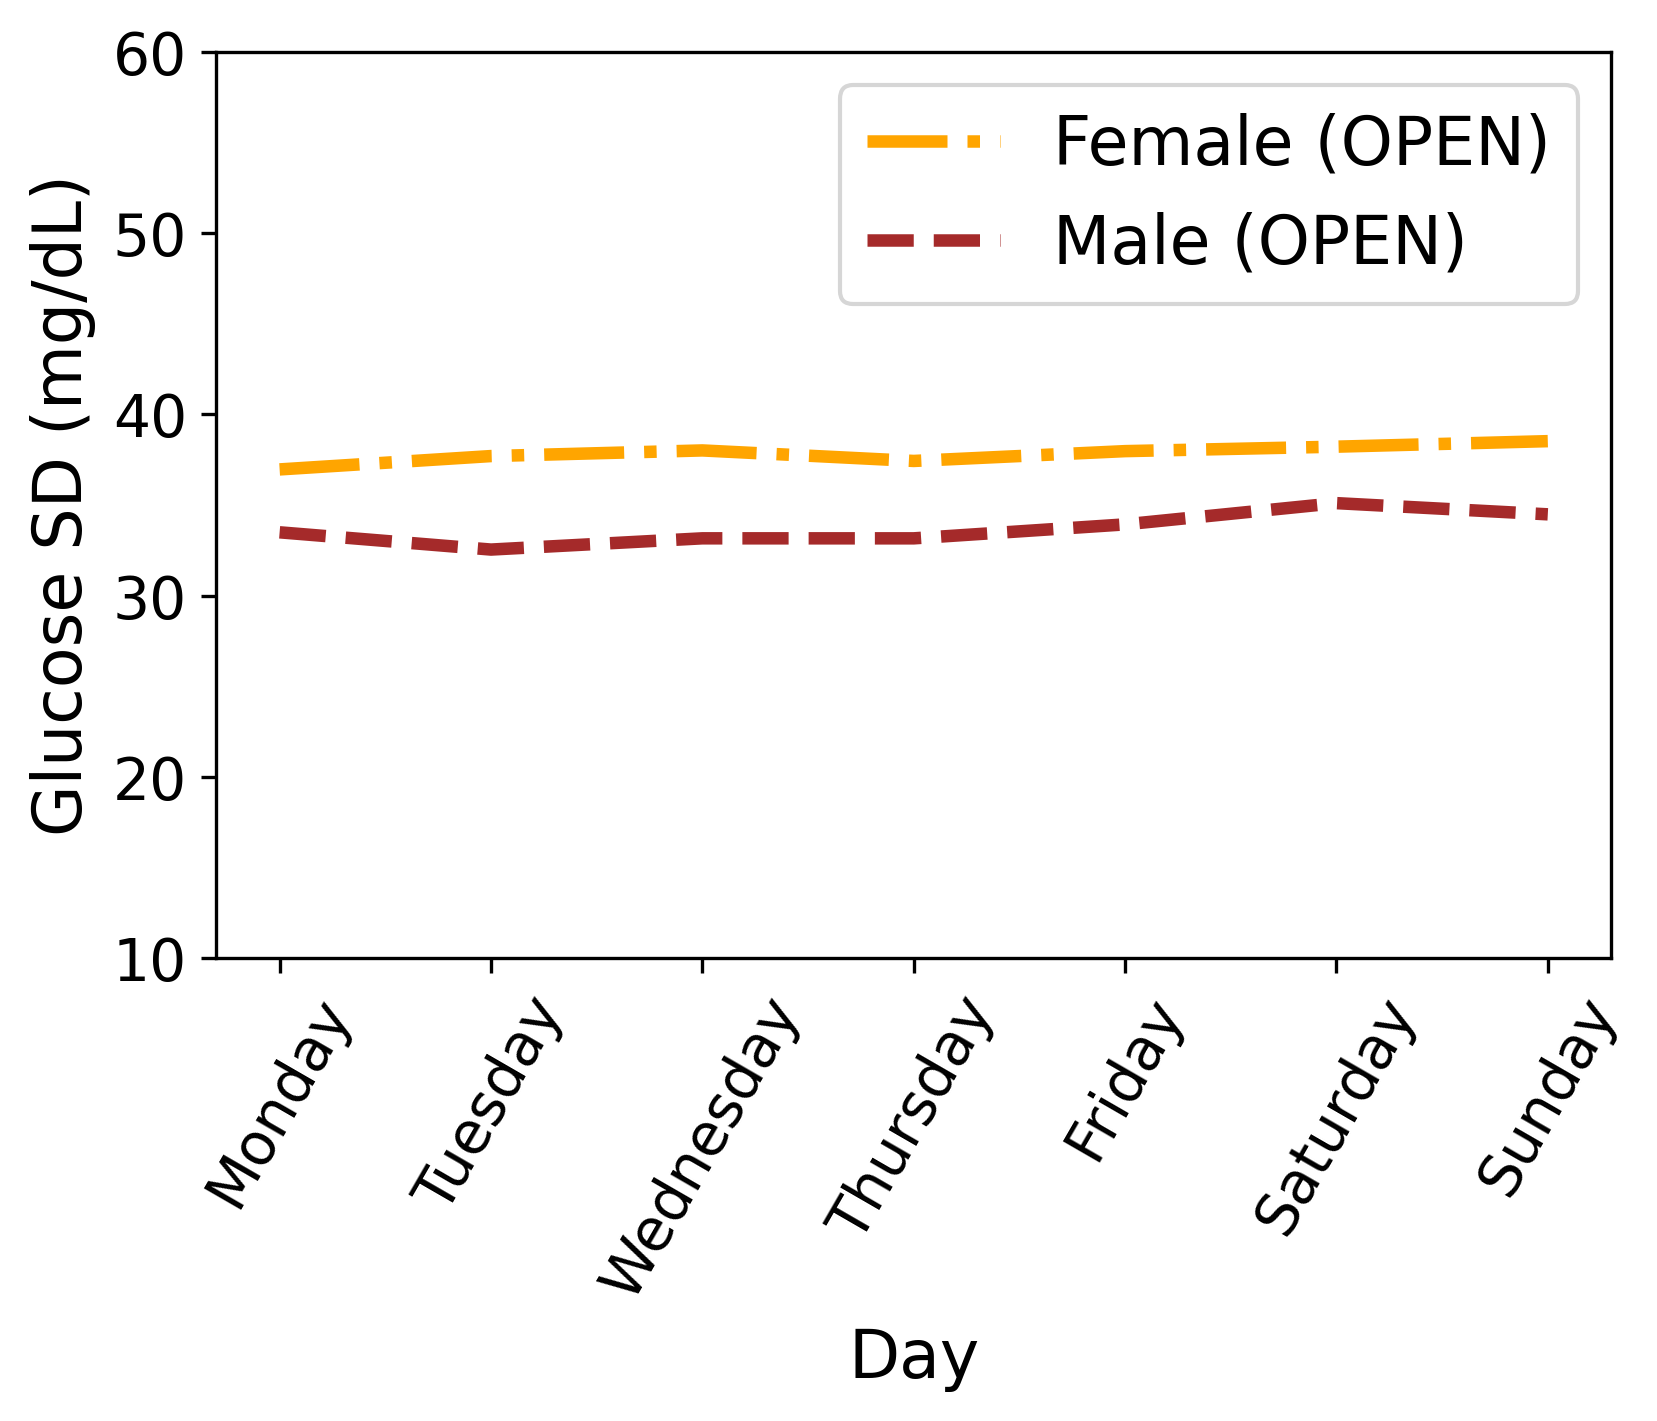

In [19]:
path = r'/home/reinhold/Daten/Paper_Datasets_Nov2022/results/daily/'  # specify data path

extension = 'csv'

OPENonOH_only = True
suffix = ""
if OPENonOH_only:
    suffix = "_OPENonOH_only"

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
days = [i.split('_', 1)[0][0].upper() + i.split('_', 1)[0][1:] for i in files]  # capitalize first letter

i = 0
mean = []
std = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean.append(df['mean'].mean())
    std.append(df['std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'days': days,
    'mean': mean,
    'std': std,
    'data': files_unstrip_IDs,
})

all_stat = pd.concat([stats], axis=1)

all_stat.sort_values('data', inplace=True, ascending=False)
all_stat.reset_index(drop=True, inplace=True)

statt = all_stat[['mean', 'data', 'days', 'std']].sort_values('data')

sorter = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
]
sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['Day_id'] = statt.index
statt['Day_id'] = statt['days'].map(sorterIndex)

statt.sort_values('Day_id', inplace=True)

#print(statt)

da_f = statt[statt['data'] == 'stats_f.csv']
da_m = statt[statt['data'] == 'stats_m.csv']

def print_KPIs():
    print("OpenAPS:")
    print("female mean min: ", da_f['mean'].min(), da_f.loc[da_f['mean'].min()==da_f['mean'], 'days'])
    print("female mean max: ", da_f['mean'].max(), da_f.loc[da_f['mean'].max()==da_f['mean'], 'days'])
    print("male mean min: ", da_m['mean'].min(), da_m.loc[da_m['mean'].min()==da_m['mean'], 'days'])
    print("male mean max: ", da_m['mean'].max(), da_m.loc[da_m['mean'].max()==da_m['mean'], 'days'])

    print("OPENonOH: mean")
    print("female mean min: ", df3["DoW"]["Female"]['sgv_mean'].min(), df3["DoW"]["Female"].loc[df3["DoW"]["Female"]['sgv_mean'].min()==df3["DoW"]["Female"]['sgv_mean'], 'DoW_str'].values[0])
    print("female mean max: ", df3["DoW"]["Female"]['sgv_mean'].max(), df3["DoW"]["Female"].loc[df3["DoW"]["Female"]['sgv_mean'].max()==df3["DoW"]["Female"]['sgv_mean'], 'DoW_str'].values[0])
    print("male mean min: ", df3["DoW"]["Male"]['sgv_mean'].min(), df3["DoW"]["Male"].loc[df3["DoW"]["Male"]['sgv_mean'].min()==df3["DoW"]["Male"]['sgv_mean'], 'DoW_str'].values[0])
    print("male mean max: ", df3["DoW"]["Male"]['sgv_mean'].max(), df3["DoW"]["Male"].loc[df3["DoW"]["Male"]['sgv_mean'].max()==df3["DoW"]["Male"]['sgv_mean'], 'DoW_str'].values[0])

    print("OPENonOH: std")
    print("female std min: ", df3["DoW"]["Female"]['sgv_std'].min(), df3["DoW"]["Female"].loc[df3["DoW"]["Female"]['sgv_std'].min()==df3["DoW"]["Female"]['sgv_std'], 'DoW_str'].values[0])
    print("female_std max: ", df3["DoW"]["Female"]['sgv_std'].max(), df3["DoW"]["Female"].loc[df3["DoW"]["Female"]['sgv_std'].max()==df3["DoW"]["Female"]['sgv_std'], 'DoW_str'].values[0])
    print("male std min: ", df3["DoW"]["Male"]['sgv_std'].min(), df3["DoW"]["Male"].loc[df3["DoW"]["Male"]['sgv_std'].min()==df3["DoW"]["Male"]['sgv_std'], 'DoW_str'].values[0])
    print("male std max: ", df3["DoW"]["Male"]['sgv_std'].max(), df3["DoW"]["Male"].loc[df3["DoW"]["Male"]['sgv_std'].max()==df3["DoW"]["Male"]['sgv_std'], 'DoW_str'].values[0])

## Plotting data



# Designate a figure size and font size
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})

plt.ylim(70, 180)
if not OPENonOH_only:
    ax = plt.plot(da_f['days'],
              da_f['mean'],
              color='blue',
              linestyle='-.',
              linewidth=3)
    ax = plt.plot(da_m['days'],
              da_m['mean'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["DoW"]["Female"]['DoW_str'],
              df3["DoW"]["Female"]['sgv_mean'],
              color='orange' if OPENonOH_only else 'red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["DoW"]["Male"]['DoW_str'],
              df3["DoW"]["Male"]['sgv_mean'],
              color='brown' if OPENonOH_only else 'red',
              linestyle='--',
              linewidth=3)

if OPENonOH_only:
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])
else:
    plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPEN)', 'Male (OPEN)'])
plt.xlabel('Day')
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=60)
#plt.show()
plt.savefig('DoW_mean.png', DPI=300)

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(10, 60)
if not OPENonOH_only:
    ax = plt.plot(da_f['days'],
              da_f['std'],
              color='blue',
              linestyle='-.',
              linewidth=3)
    ax = plt.plot(da_m['days'],
              da_m['std'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["DoW"]["Female"]['DoW_str'],
              df3["DoW"]["Female"]['sgv_std'],
              color='orange' if OPENonOH_only else 'red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["DoW"]["Male"]['DoW_str'],
              df3["DoW"]["Male"]['sgv_std'],
              color='brown' if OPENonOH_only else 'red',
              linestyle='--',
              linewidth=3)

if OPENonOH_only:
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])
else:
    plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPEN)', 'Male (OPEN)'])

plt.xlabel('Day')
plt.ylabel('Glucose SD (mg/dL)')
plt.xticks(rotation=60)
#plt.show()
plt.savefig('DoW_std.png', DPI=300)


# Plot hourly average statistics

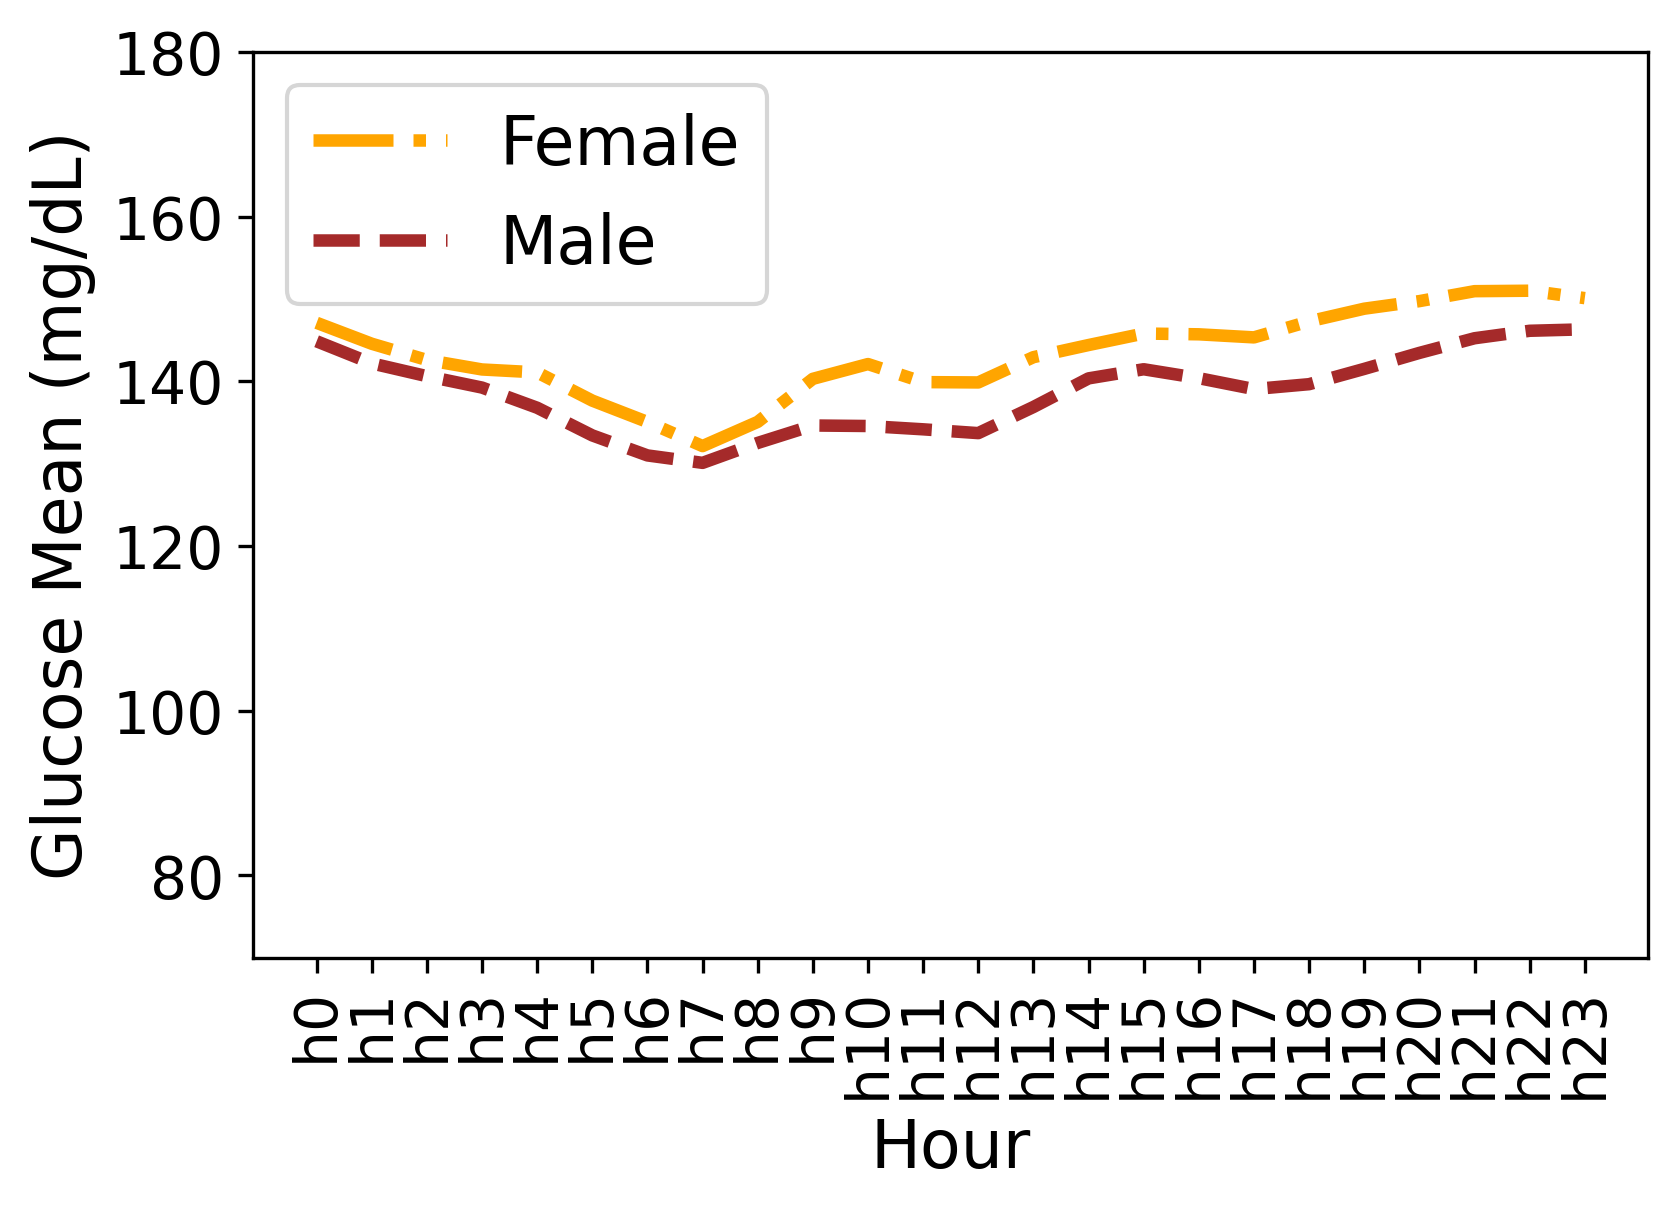

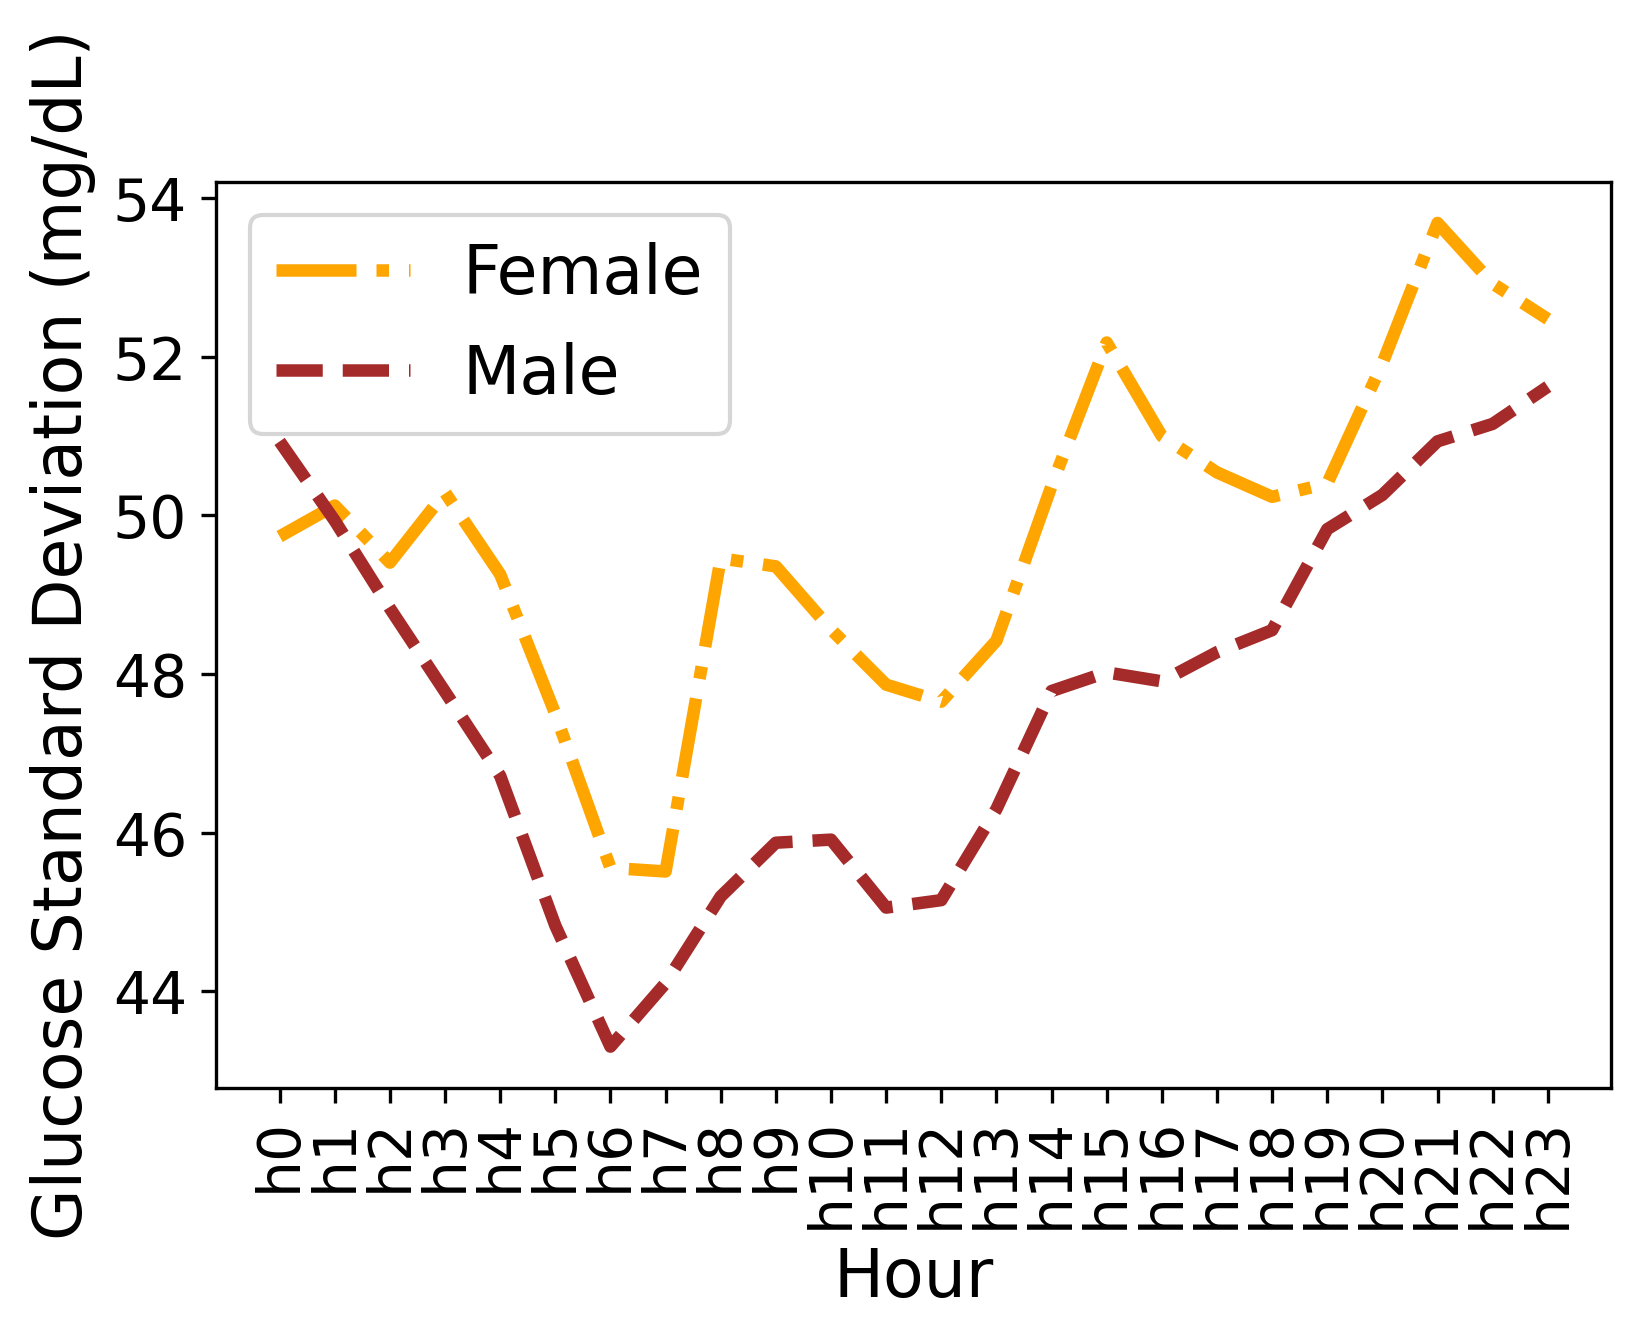

In [23]:
path = r'/home/reinhold/Daten/Paper_Datasets_Nov2022/results/hourly/'  # specify data path
plt.rcParams.update({'font.size': 30, 'legend.fontsize': 16, 'legend.title_fontsize': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14})
extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
hours = [i.split('_', 1)[0] for i in files]

i = 0
mean_m = []
std_m = []

mean_f = []
std_f = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean_m.append(df.loc[df['gender'] == 'Male', 'mean'].mean())
    std_m.append(df.loc[df['gender'] == 'Male', 'std'].mean())

    mean_f.append(df.loc[df['gender'] == 'Female', 'mean'].mean())
    std_f.append(df.loc[df['gender'] == 'Female', 'std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'hours': hours,
    'mean_m': mean_m,
    'std_m': std_m,
    'mean_f': mean_f,
    'std_f': std_f
})

statt = pd.concat([stats], axis=1).sort_values('hours')

#all_stat.sort_values('data',inplace=True, ascending=False)
#all_stat.reset_index(drop=True, inplace=True)

#print(all_stat)

sorter = [
    'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11',
    'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21',
    'h22', 'h23'
]

sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['hour_id'] = statt.index
statt['hour_id'] = statt['hours'].map(sorterIndex)

statt.sort_values('hour_id', inplace=True)

## Plotting data

# Designate a figure size and font size
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(70, 180)
ax = plt.plot(statt['hours'],
              statt['mean_f'],
              color='orange',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(statt['hours'],
              statt['mean_m'],
              color='brown',
              linestyle='--',
              linewidth=3)

plt.legend(['Female', 'Male'])
plt.xlabel('Hour')
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=90)
plt.show()

##

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})

ax = plt.plot(statt['hours'],
              statt['std_f'],
              color='orange',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(statt['hours'],
              statt['std_m'],
              color='brown',
              linestyle='--',
              linewidth=3)

plt.legend(['Female', 'Male'])
plt.xlabel('Hour')
plt.ylabel('Glucose Standard Deviation (mg/dL)')
plt.xticks(rotation=90)
plt.show()

#statt

In [24]:
path = "/home/reinhold/Daten/Paper_Datasets_Nov2022/results/hourly_OPENonOH"
df_hourly_F = pd.read_csv(os.path.join(path,"OPENonOH_hourly_Female2.csv"))
df_hourly_M = pd.read_csv(os.path.join(path,"OPENonOH_hourly_Male2.csv"))


df4_F = df_hourly_F.groupby(by="hour", as_index=False).agg({"sgv_mean": "mean", "sgv_std": "mean", "pm_id": "count"})
df4_M = df_hourly_M.groupby(by="hour", as_index=False).agg({"sgv_mean": "mean", "sgv_std": "mean", "pm_id": "count"})

sorter = [
    'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11',
    'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21',
    'h22', 'h23'
]

df4_F.reset_index(drop=True, inplace=True)
df4_M.reset_index(drop=True, inplace=True)
df4_F.columns = ["hour", "sgv_mean_mean", "sgv_std_mean", "pm_id_count"]
df4_M.columns = ["hour", "sgv_mean_mean", "sgv_std_mean", "pm_id_count"]
df4_F["hour"] = sorter
df4_M["hour"] = sorter
df4_F.info()
df4_M.info()

#print(df4_F.head())
#print(df4_M.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hour           24 non-null     object 
 1   sgv_mean_mean  24 non-null     float64
 2   sgv_std_mean   24 non-null     float64
 3   pm_id_count    24 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 896.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hour           24 non-null     object 
 1   sgv_mean_mean  24 non-null     float64
 2   sgv_std_mean   24 non-null     float64
 3   pm_id_count    24 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 896.0+ bytes


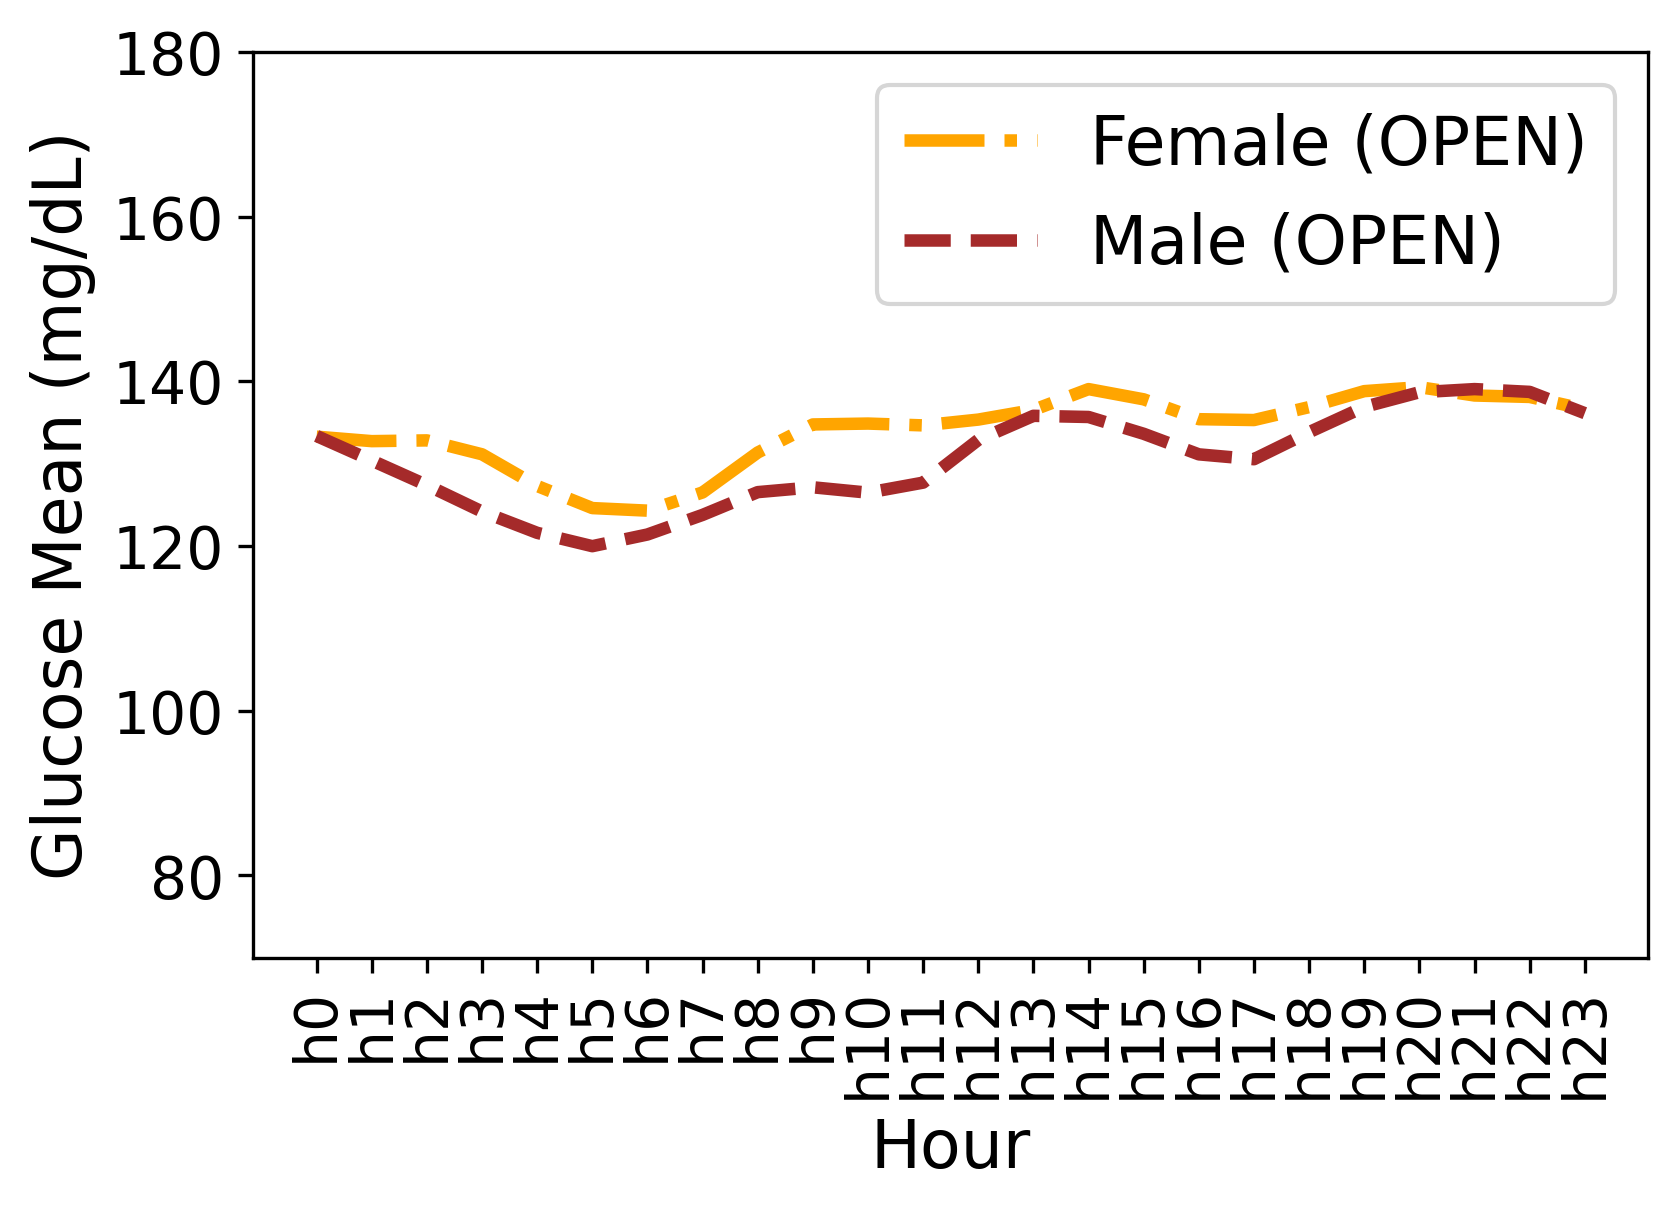

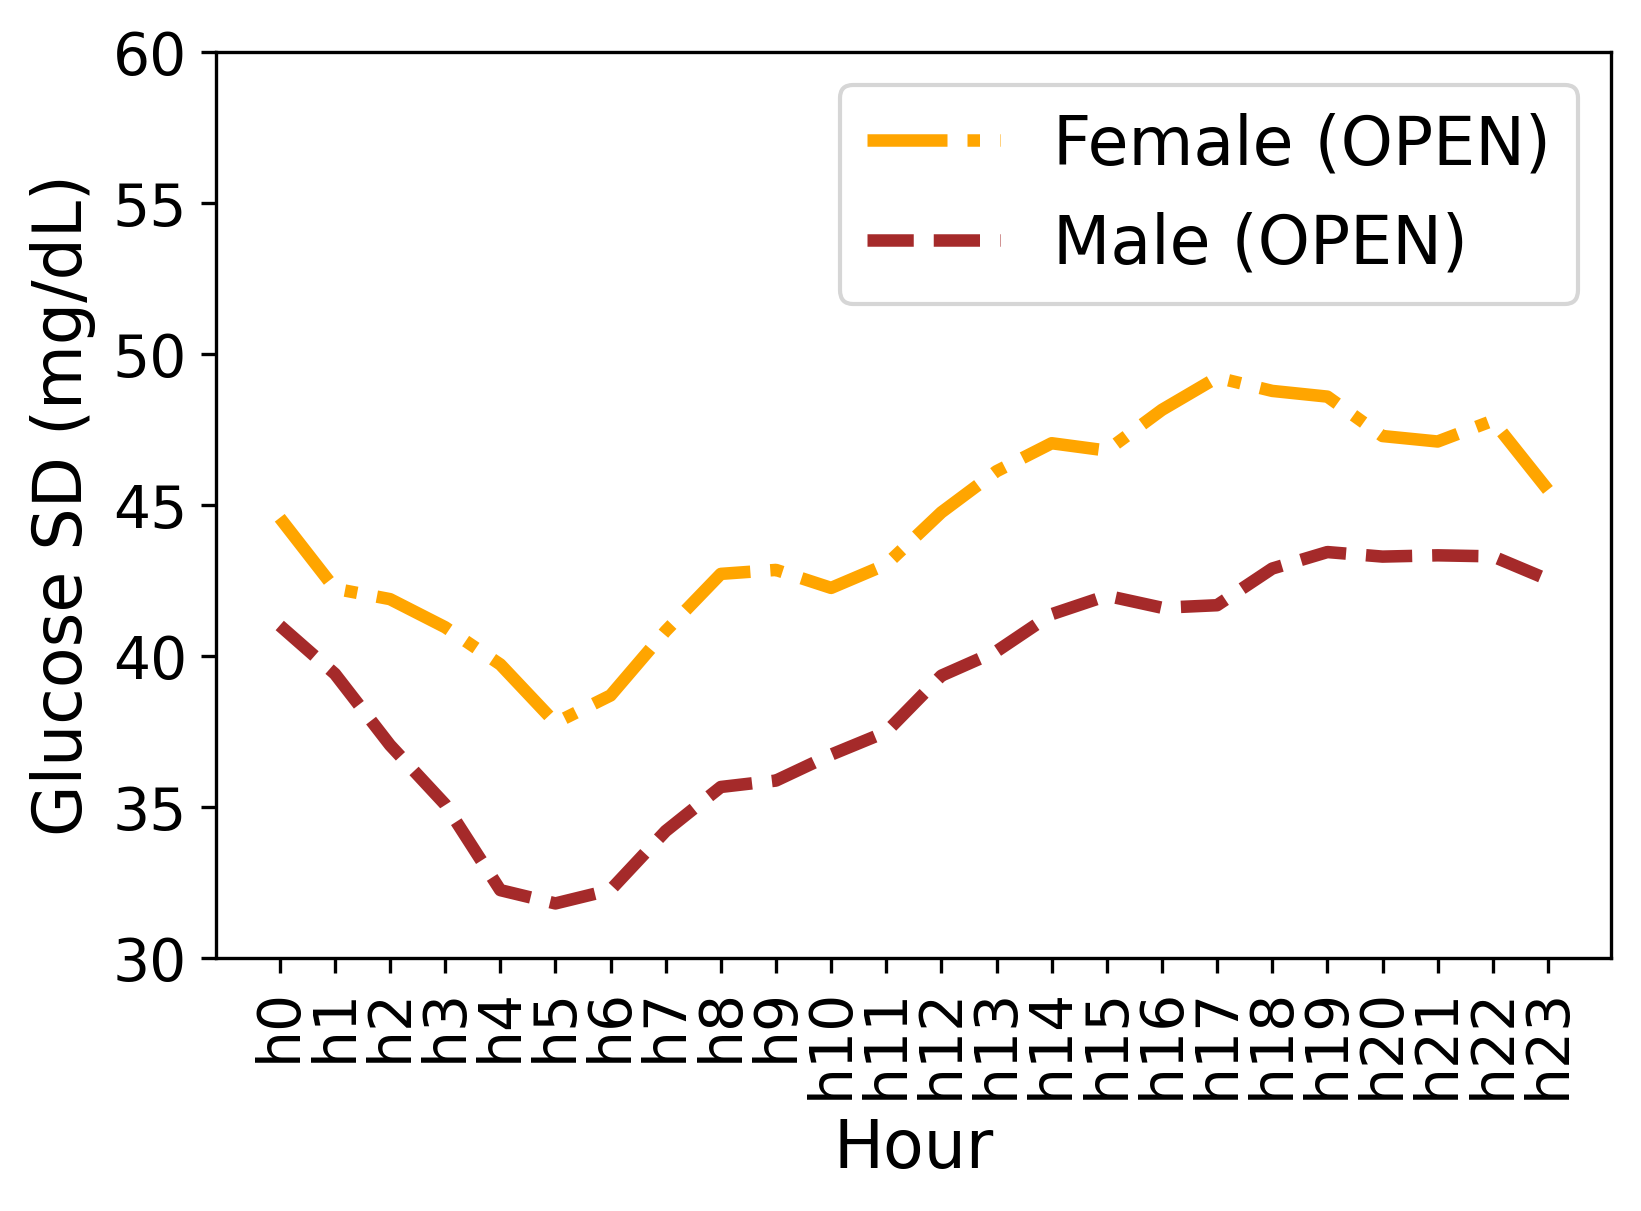

In [26]:
# OpenAPS
path = r'/home/reinhold/Daten/Paper_Datasets_Nov2022/results/hourly/'  # specify data path

extension = 'csv'

os.chdir(path)

OPENonOH_only = True

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
hours = [i.split('_', 1)[0] for i in files]

i = 0
mean_m = []
std_m = []

mean_f = []
std_f = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean_m.append(df.loc[df['gender'] == 'Male', 'mean'].mean())
    std_m.append(df.loc[df['gender'] == 'Male', 'std'].mean())

    mean_f.append(df.loc[df['gender'] == 'Female', 'mean'].mean())
    std_f.append(df.loc[df['gender'] == 'Female', 'std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'hours': hours,
    'mean_m': mean_m,
    'std_m': std_m,
    'mean_f': mean_f,
    'std_f': std_f
})

statt = pd.concat([stats], axis=1).sort_values('hours')

#all_stat.sort_values('data',inplace=True, ascending=False)
#all_stat.reset_index(drop=True, inplace=True)

#print(all_stat)

sorter = [
    'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11',
    'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21',
    'h22', 'h23'
]

sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['hour_id'] = statt.index
statt['hour_id'] = statt['hours'].map(sorterIndex)

statt.sort_values('hour_id', inplace=True)

def print_KPIs():
    # print statistical values
    print("OpenAPS: mean")
    print("female mean min: ", statt['mean_f'].min(), statt.loc[statt['mean_f'].min()==statt['mean_f'], 'hours'].values[0])
    print("female mean max: ", statt['mean_f'].max(), statt.loc[statt['mean_f'].max()==statt['mean_f'], 'hours'].values[0])
    print("male mean min: ", statt['mean_m'].min(), statt.loc[statt['mean_m'].min()==statt['mean_m'], 'hours'].values[0])
    print("male mean max: ", statt['mean_m'].max(), statt.loc[statt['mean_m'].max()==statt['mean_m'], 'hours'].values[0])

    print("OpenAPS: std")
    print("female std min: ", statt['std_f'].min(), statt.loc[statt['std_f'].min()==statt['std_f'], 'hours'].values[0])
    print("female std max: ", statt['std_f'].max(), statt.loc[statt['std_f'].max()==statt['std_f'], 'hours'].values[0])
    print("male std min: ", statt['std_m'].min(), statt.loc[statt['std_m'].min()==statt['std_m'], 'hours'].values[0])
    print("male std max: ", statt['std_m'].max(), statt.loc[statt['std_m'].max()==statt['std_m'], 'hours'].values[0])


    print("OPENonOH: mean")
    print("female mean min: ", df4_F['sgv_mean_mean'].min(), df4_F.loc[df4_F['sgv_mean_mean'].min()==df4_F['sgv_mean_mean'], 'hour'].values[0])
    print("female mean mean: ", df4_F['sgv_mean_mean'].mean())
    print("female mean max: ", df4_F['sgv_mean_mean'].max(), df4_F.loc[df4_F['sgv_mean_mean'].max()==df4_F['sgv_mean_mean'], 'hour'].values[0])
    print("male mean min: ", df4_M['sgv_mean_mean'].min(), df4_M.loc[df4_M['sgv_mean_mean'].min()==df4_M['sgv_mean_mean'], 'hour'].values[0])
    print("male mean mean: ", df4_M['sgv_mean_mean'].mean())
    print("male mean max: ", df4_M['sgv_mean_mean'].max(), df4_M.loc[df4_M['sgv_mean_mean'].max()==df4_M['sgv_mean_mean'], 'hour'].values[0])

    print("OPENonOH: std")
    print("female std min: ", df4_F['sgv_std_mean'].min(), df4_F.loc[df4_F['sgv_std_mean'].min()==df4_F['sgv_std_mean'], 'hour'].values[0])
    print("female std mean: ", df4_F['sgv_std_mean'].mean())
    print("female_std max: ", df4_F['sgv_std_mean'].max(), df4_F.loc[df4_F['sgv_std_mean'].max()==df4_F['sgv_std_mean'], 'hour'].values[0])
    print("male std min: ", df4_M['sgv_std_mean'].min(), df4_M.loc[df4_M['sgv_std_mean'].min()==df4_M['sgv_std_mean'], 'hour'].values[0])
    print("male std mean: ", df4_M['sgv_std_mean'].mean())
    print("male std max: ", df4_M['sgv_std_mean'].max(), df4_M.loc[df4_M['sgv_std_mean'].max()==df4_M['sgv_std_mean'], 'hour'].values[0])



## Plotting data

# Designate a figure size and font size
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(70, 180)
if not OPENonOH_only:
    ax = plt.plot(statt['hours'],
                statt['mean_f'],
                color='blue',
                linestyle='-.',
                linewidth=3)
    ax = plt.plot(statt['hours'],
                statt['mean_m'],
                color='blue',
                linestyle='--',
                linewidth=3)
ax = plt.plot(df4_F['hour'],
              df4_F['sgv_mean_mean'],
              color='orange' if OPENonOH_only else 'red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df4_M['hour'],
              df4_M['sgv_mean_mean'],
              color='brown' if OPENonOH_only else 'red',
              linestyle='--',
              linewidth=3)


if OPENonOH_only:
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])
else:
    plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPEN)', 'Male (OPEN)'])

plt.xlabel('Hour')
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=90)
#plt.show()

##

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})

if not OPENonOH_only:
    ax = plt.plot(statt['hours'],
                statt['std_f'],
                color='blue',
                linestyle='-.',
                linewidth=3)
    ax = plt.plot(statt['hours'],
                statt['std_m'],
                color='blue',
                linestyle='--',
                linewidth=3)

ax = plt.plot(df4_F['hour'],
              df4_F['sgv_std_mean'],
              color='orange' if OPENonOH_only else 'red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df4_M['hour'],
              df4_M['sgv_std_mean'],
              color='brown' if OPENonOH_only else 'red',
              linestyle='--',
              linewidth=3)

if OPENonOH_only:
    plt.ylim((30, 60))
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])
else:
    plt.ylim((30, 80))
    plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPEN)', 'Male (OPEN)'])

plt.xlabel('Hour')
plt.ylabel('Glucose SD (mg/dL)')
plt.xticks(rotation=90)
plt.show()






# Average Statistics based on Monthly Breakdown 

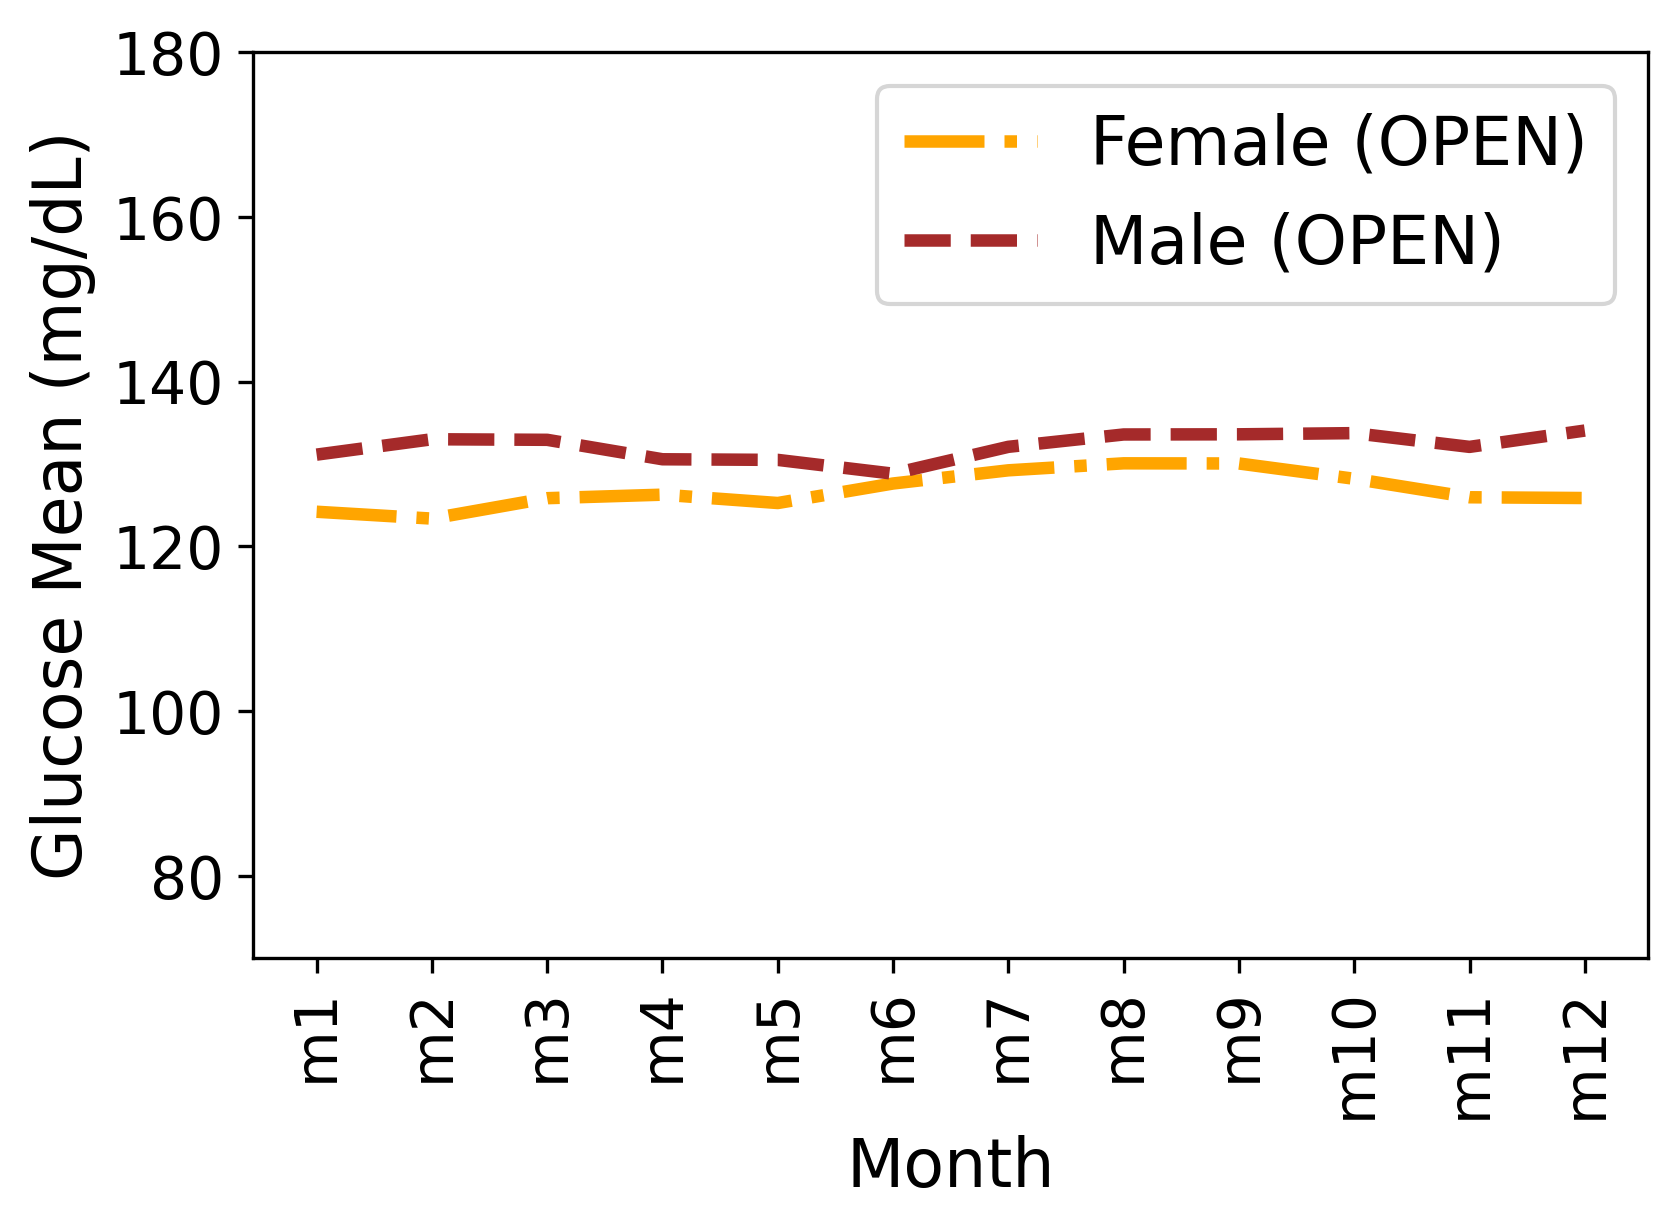

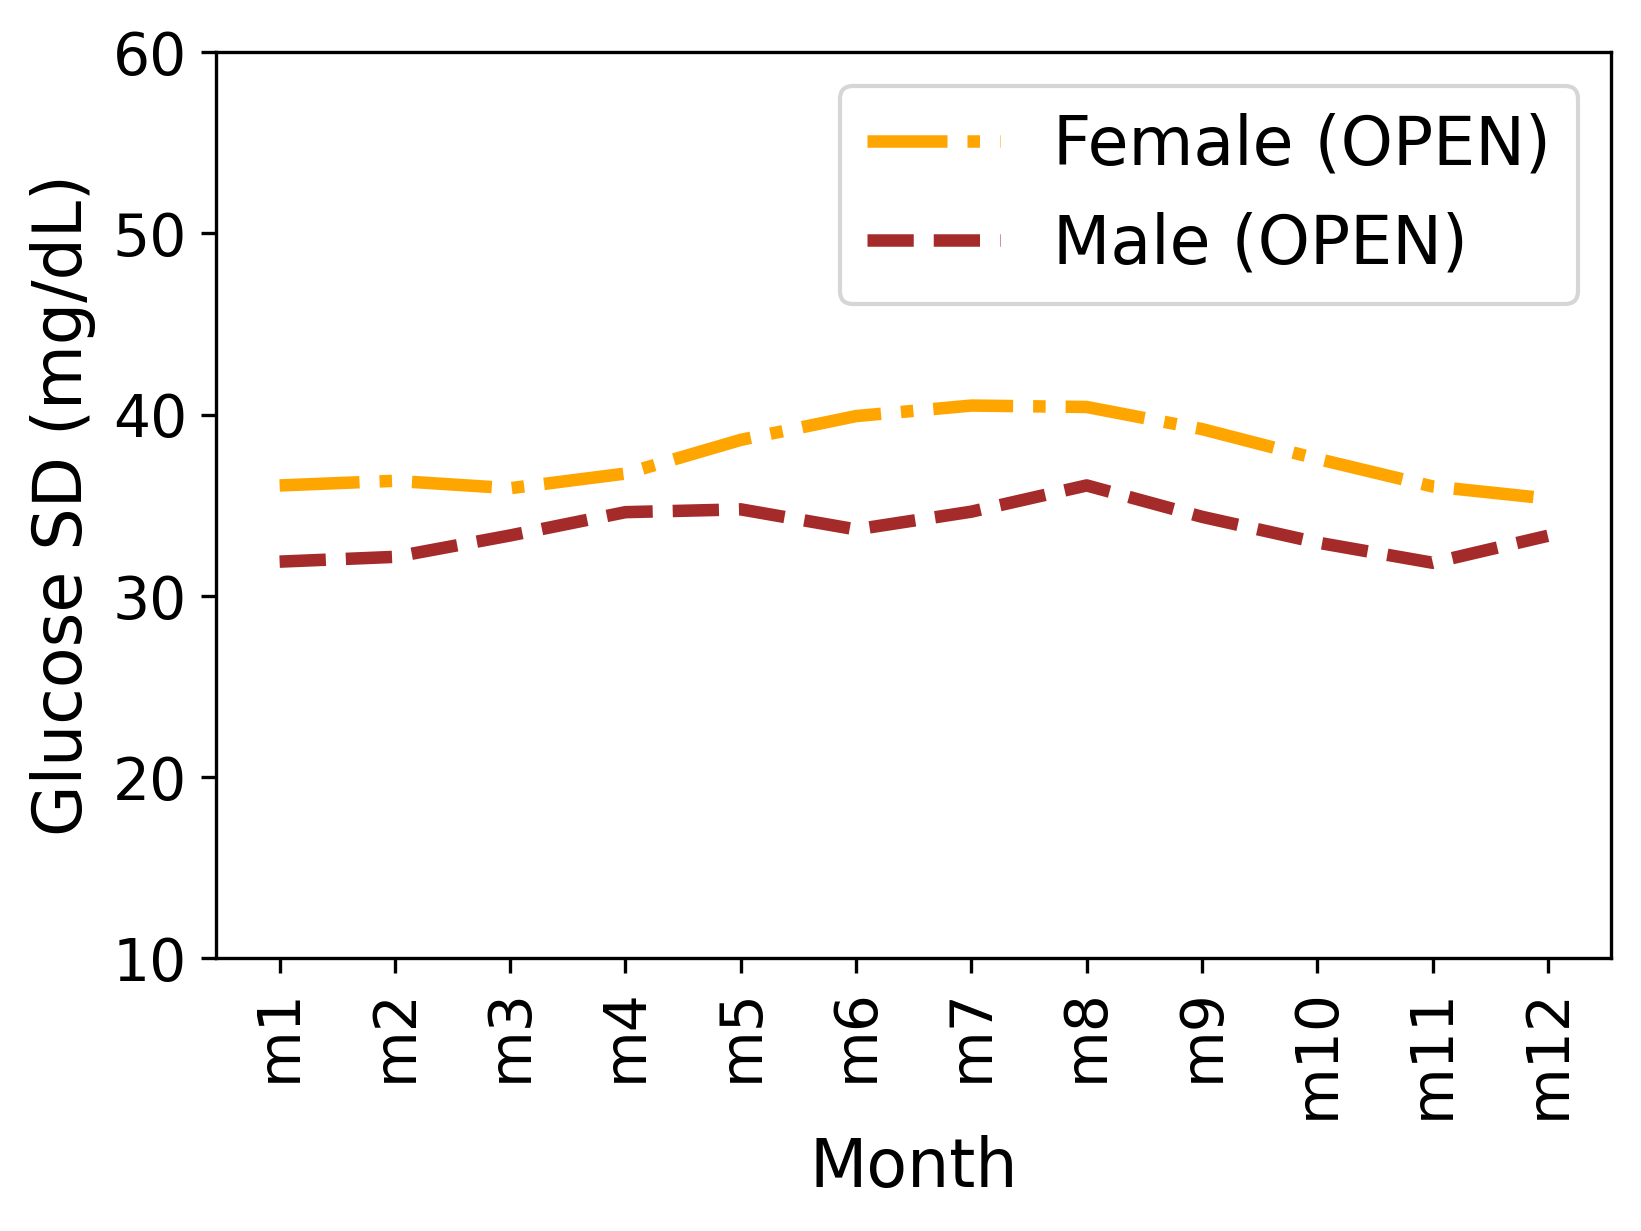

In [27]:
path = r'/home/reinhold/Daten/Paper_Datasets_Nov2022/results/monthly/'  # specify data path

OPENonOH_only = True

extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
months = [i.split('_', 1)[0] for i in files]

i = 0
mean_m = []
std_m = []

mean_f = []
std_f = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean_m.append(df.loc[df['gender'] == 'Male', 'mean'].mean())
    std_m.append(df.loc[df['gender'] == 'Male', 'std'].mean())

    mean_f.append(df.loc[df['gender'] == 'Female', 'mean'].mean())
    std_f.append(df.loc[df['gender'] == 'Female', 'std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'months': months,
    'mean_m': mean_m,
    'std_m': std_m,
    'mean_f': mean_f,
    'std_f': std_f
})

statt = pd.concat([stats], axis=1).sort_values('months')

sorter = [
    'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
]

sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['month_id'] = statt.index
statt['month_id'] = statt['months'].map(sorterIndex)

statt.sort_values('month_id', inplace=True)

#df3["day"]["Female"].reset_index(inplace=True)
#reset_index(inplace=True)
#df3["month"]["Male"].reset_index(inplace=True)

#print(df3["month"]["Female"]["month"])
df3["month"]["Female"]["month_str"] = df3["month"]["Female"]['month'].apply(lambda x: f"m{x}")
df3["month"]["Female"]["month_id"] = df3["month"]["Female"]['month_str'].map(sorterIndex)
df3["month"]["Female"].sort_values('month_id', inplace=True)

#df3["month"]["Male"].sort_values('month', inplace=True)
df3["month"]["Male"]["month_str"] = df3["month"]["Male"]['month'].apply(lambda x: f"m{x}")
df3["month"]["Male"]["month_id"] = df3["month"]["Male"]['month_str'].map(sorterIndex)
df3["month"]["Male"].sort_values('month_id', inplace=True)

## Plotting data

# Designate a figure size and font size
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})

plt.ylim(70, 180)

if not OPENonOH_only:
    ax = plt.plot(statt['months'],
              statt['mean_f'],
              color='blue',
              linestyle='-.',
              linewidth=3)
    ax = plt.plot(statt['months'],
              statt['mean_m'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["month"]["Female"]['month_str'],
              df3["month"]["Female"]['sgv_mean'],
              color='orange' if OPENonOH_only else 'red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["month"]["Male"]['month_str'],
              df3["month"]["Male"]['sgv_mean'],
              color='brown' if OPENonOH_only else 'red',
              linestyle='--',
              linewidth=3)

if OPENonOH_only:
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])
else:
    plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPEN)', 'Male (OPEN)'])
plt.xlabel('Month')
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=90)
plt.show()

##

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(10, 60)

if not OPENonOH_only:
    ax = plt.plot(statt['months'],
              statt['std_f'],
              color='blue',
              linestyle='-.',
              linewidth=3)
    ax = plt.plot(statt['months'],
              statt['std_m'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["month"]["Female"]['month_str'],
              df3["month"]["Female"]['sgv_std'],
              color='orange' if OPENonOH_only else 'red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["month"]["Male"]['month_str'],
              df3["month"]["Male"]['sgv_std'],
              color='brown' if OPENonOH_only else 'red',
              linestyle='--',
              linewidth=3)

if OPENonOH_only:
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])
else:
    plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPEN)', 'Male (OPEN)'])
plt.xlabel('Month')
plt.ylabel('Glucose SD (mg/dL)')
plt.xticks(rotation=90)
plt.show()

# Average Statistics based on Date of Month Breakdown 

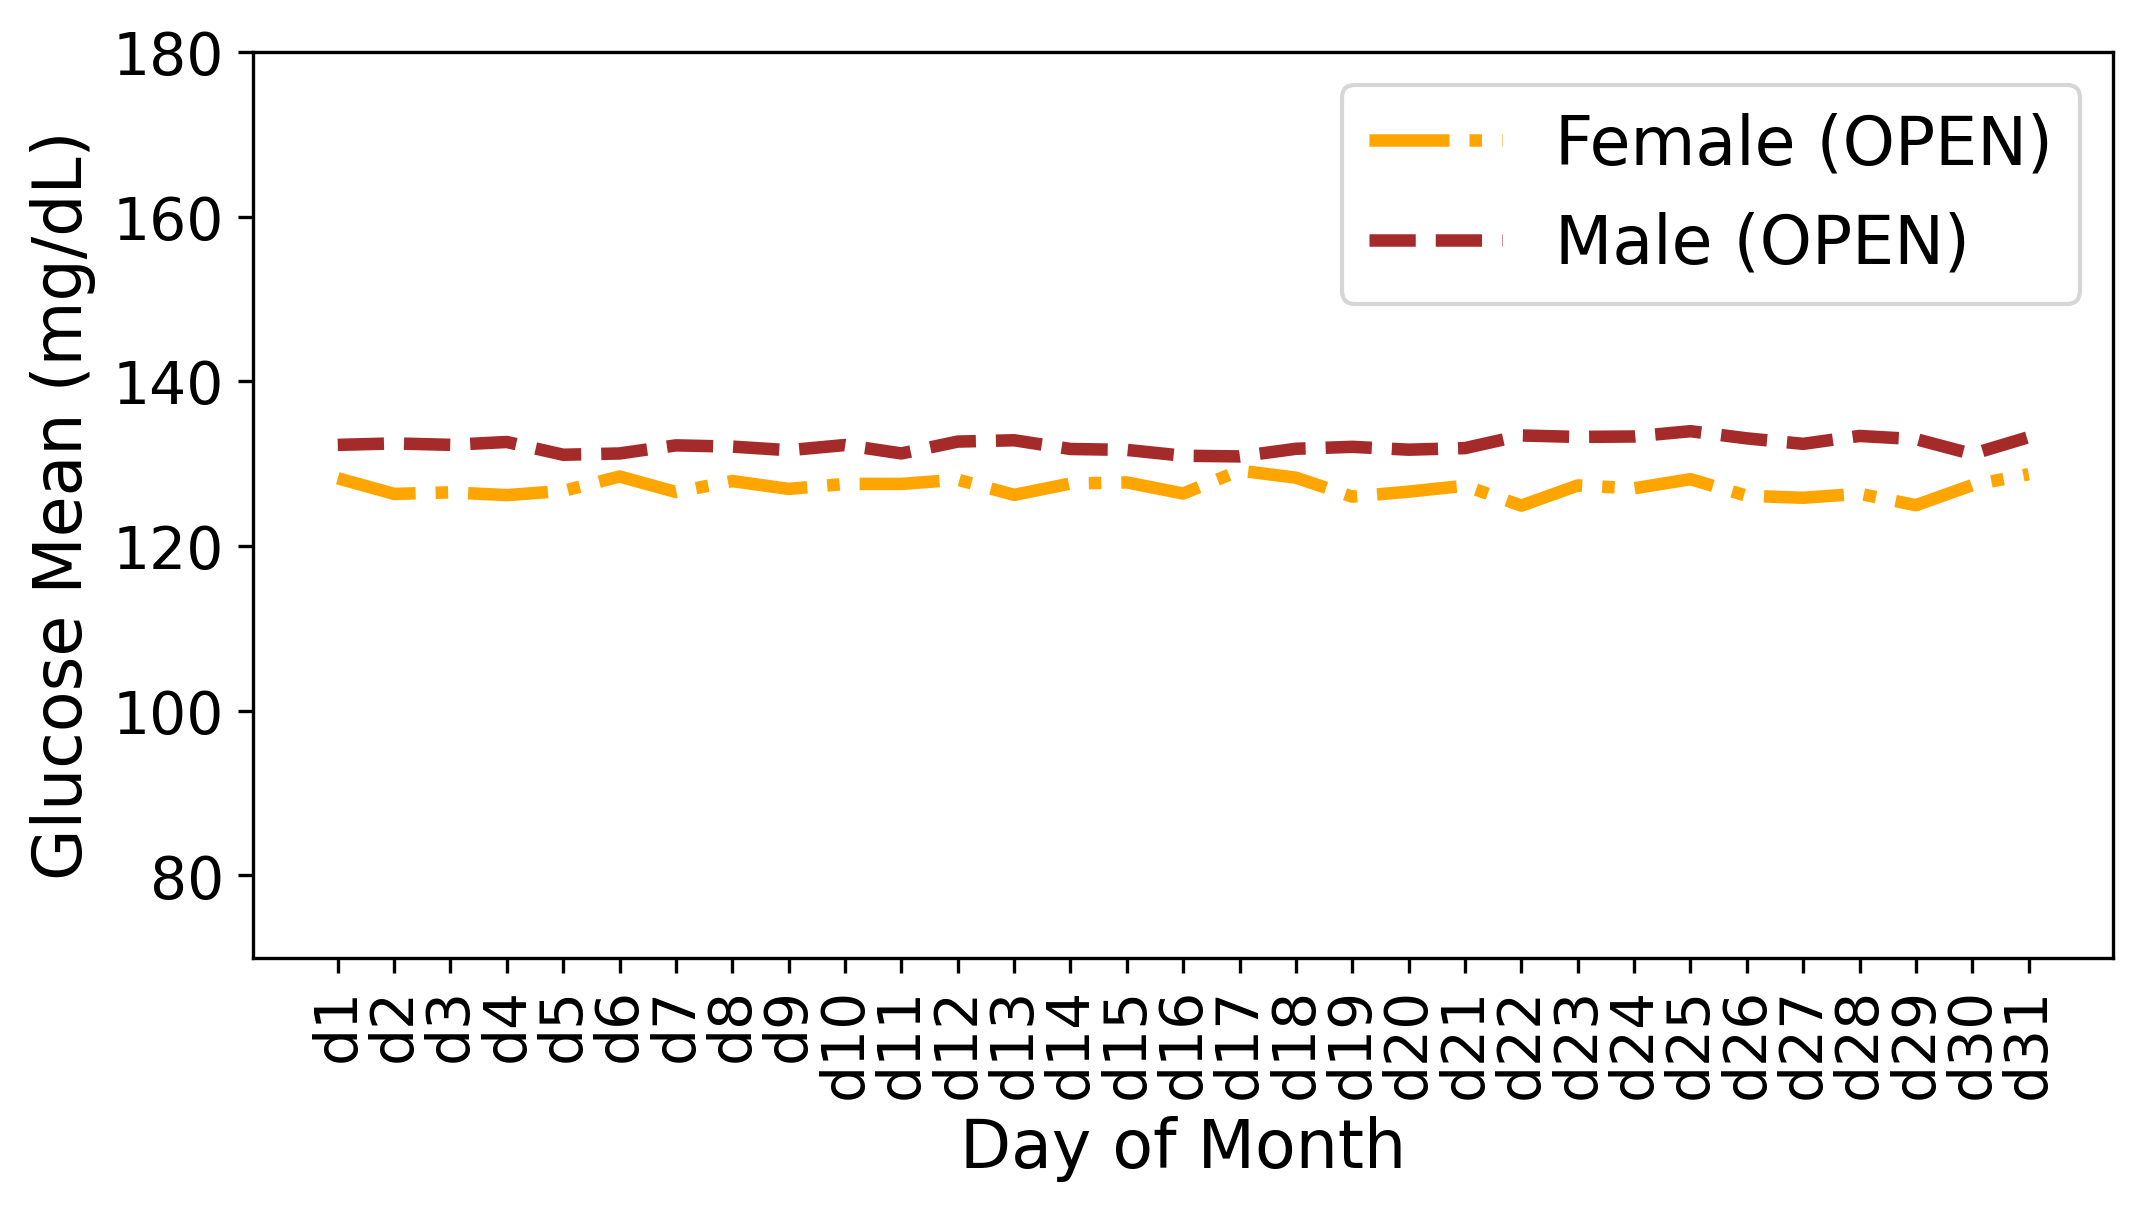

<Figure size 1800x1200 with 0 Axes>

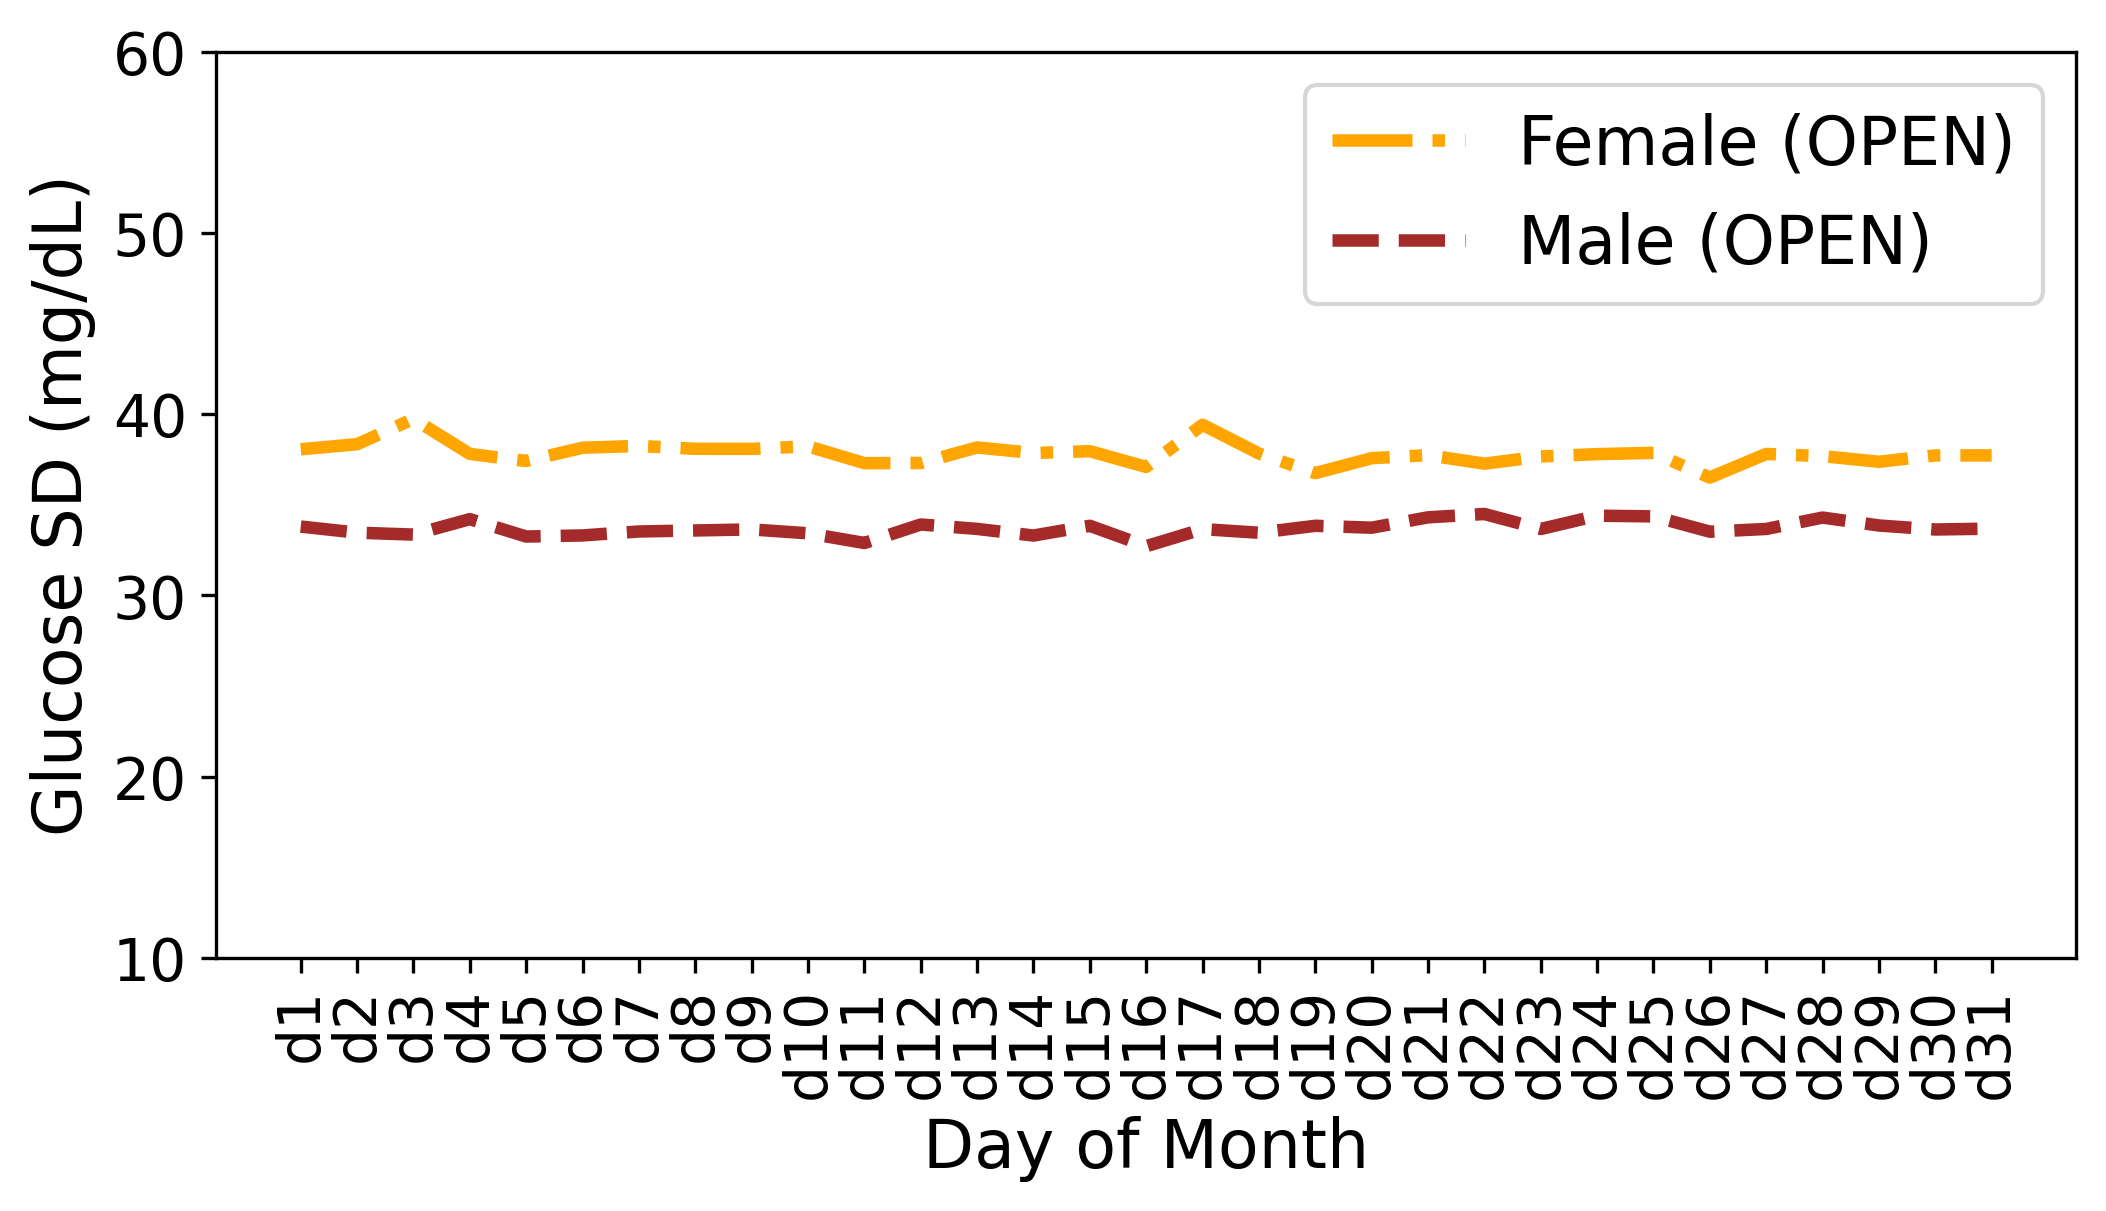

<Figure size 1800x1200 with 0 Axes>

In [28]:
path = r'/home/reinhold/Daten/Paper_Datasets_Nov2022/results/dateofmonth/'  # specify data path

OPENonOH_only = True

extension = 'csv'

os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]
files_unstrip_IDs = [i.split('_', 1)[1] for i in files]
date = [i.split('_', 1)[0] for i in files]

i = 0
mean_m = []
std_m = []

mean_f = []
std_f = []

for f in files:
    p = os.path.join(path, f)

    # reading and processing files
    df = pd.read_csv(p, index_col=None, na_values=" null")

    mean_m.append(df.loc[df['gender'] == 'Male', 'mean'].mean())
    std_m.append(df.loc[df['gender'] == 'Male', 'std'].mean())

    mean_f.append(df.loc[df['gender'] == 'Female', 'mean'].mean())
    std_f.append(df.loc[df['gender'] == 'Female', 'std'].mean())

    i = i + 1

stats = pd.DataFrame({
    'date': date,
    'mean_m': mean_m,
    'std_m': std_m,
    'mean_f': mean_f,
    'std_f': std_f
})

statt = pd.concat([stats], axis=1).sort_values('date')

#all_stat.sort_values('data',inplace=True, ascending=False)
#all_stat.reset_index(drop=True, inplace=True)

#print(all_stat)

sorter = [
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12',
    'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22',
    'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31'
]

sorterIndex = dict(zip(sorter, range(len(sorter))))

statt['date_id'] = statt.index
statt['date_id'] = statt['date'].map(sorterIndex)

statt.sort_values('date_id', inplace=True)

## Plotting data
df3["day"]["Female"]["day_str"] = df3["day"]["Female"]['day'].apply(lambda x: f"d{x}")
df3["day"]["Female"]["day_id"] = df3["day"]["Female"]['day_str'].map(sorterIndex)
df3["day"]["Female"].sort_values('day_id', inplace=True)

df3["day"]["Male"]["day_str"] = df3["day"]["Male"]['day'].apply(lambda x: f"d{x}")
df3["day"]["Male"]["day_id"] = df3["day"]["Male"]['day_str'].map(sorterIndex)
df3["day"]["Male"].sort_values('day_id', inplace=True)

# Designate a figure size and font size
plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 14})

plt.ylim(70, 180)
if not OPENonOH_only:
    ax = plt.plot(statt['date'],
              statt['mean_f'],
              color='blue',
              linestyle='-.',
              linewidth=3)
    ax = plt.plot(statt['date'],
              statt['mean_m'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["day"]["Female"]['day_str'],
              df3["day"]["Female"]['sgv_mean'],
              color='orange' if OPENonOH_only else 'red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["day"]["Male"]['day_str'],
              df3["day"]["Male"]['sgv_mean'],
              color='brown' if OPENonOH_only else 'red',
              linestyle='--',
              linewidth=3)
if OPENonOH_only:
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])
else:
    plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPEN)', 'Male (OPEN)'])
plt.xlabel('Day of Month')
plt.ylabel('Glucose Mean (mg/dL)')
plt.xticks(rotation=90)
plt.show()
plt.savefig(f"glucose_dayofmonth_mean{suffix}.png")
##

plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 14})
plt.ylim(10, 60)
if not OPENonOH_only:
    ax = plt.plot(statt['date'],
              statt['std_f'],
              color='blue',
              linestyle='-.',
              linewidth=3)
    ax = plt.plot(statt['date'],
              statt['std_m'],
              color='blue',
              linestyle='--',
              linewidth=3)
ax = plt.plot(df3["day"]["Female"]['day_str'],
              df3["day"]["Female"]['sgv_std'],
              color='orange' if OPENonOH_only else 'red',
              linestyle='-.',
              linewidth=3)
ax = plt.plot(df3["day"]["Male"]['day_str'],
              df3["day"]["Male"]['sgv_std'],
              color='brown' if OPENonOH_only else 'red',
              linestyle='--',
              linewidth=3)
if OPENonOH_only:
    plt.legend(['Female (OPEN)', 'Male (OPEN)'])
else:
    plt.legend(['Female (OpenAPS Data Commons)', 'Male (OpenAPS Data Commons)', 'Female (OPEN)', 'Male (OPEN)'])
plt.xlabel('Day of Month')
plt.ylabel('Glucose SD (mg/dL)')
plt.xticks(rotation=90)
plt.show()
plt.savefig(f"glucose_dayofmonth_SD{suffix}.png")
